In [1]:
%load_ext autoreload
%autoreload 2

import time
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.HH.HH import HHbbWWDoubleLeptonHardDataset,HHbbWWDoubleLeptonRecoDataset
from memflow.callbacks.transfer_flow_callbacks import *
from memflow.models.custom_flows import *

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

Checking particle quantities
	Particle(s) ('H1',) : required {2}, found {2}
	Particle(s) ('H2',) : required {2}, found {2}
	Particle(s) ('bottom',) : required {1}, found {1}
	Particle(s) ('antibottom',) : required {1}, found {1}
	Particle(s) ('W_plus',) : required {0, 1}, found {0, 1}
	Particle(s) ('W_minus',) : required {0, 1}, found {0, 1}
	Particle(s) ('Z1',) : required {0, 2}, found {0, 2}
	Particle(s) ('Z2',) : required {0, 2}, found {0, 2}
	Particle(s) ('W_plus', 'W_minus', 'Z1') : required {2}, found {2}
	Particle(s) ('lep_plus_from_W', 'lep_minus_from_W', 'neutrino_from_W', 'antineutrino_from_W') : required {0, 4}, found {0, 4}
	Particle(s) ('quark_up_from_W', 'quark_down_from_W', 'antiquark_up_from_W', 'antiquark_down_from_W') : required {0}, found {0}
	Particle(s) ('lep_plus_from_Z', 'lep_minus_from_Z', 'neutrino_from_Z', 'antineutrino_from_Z') : required {0, 4}, found {0, 4}
	Particle(s) ('quark_up_from_Z', 'quark_down_from_Z', 'antiquark_up_from_Z', 'antiquark_down_from_Z')

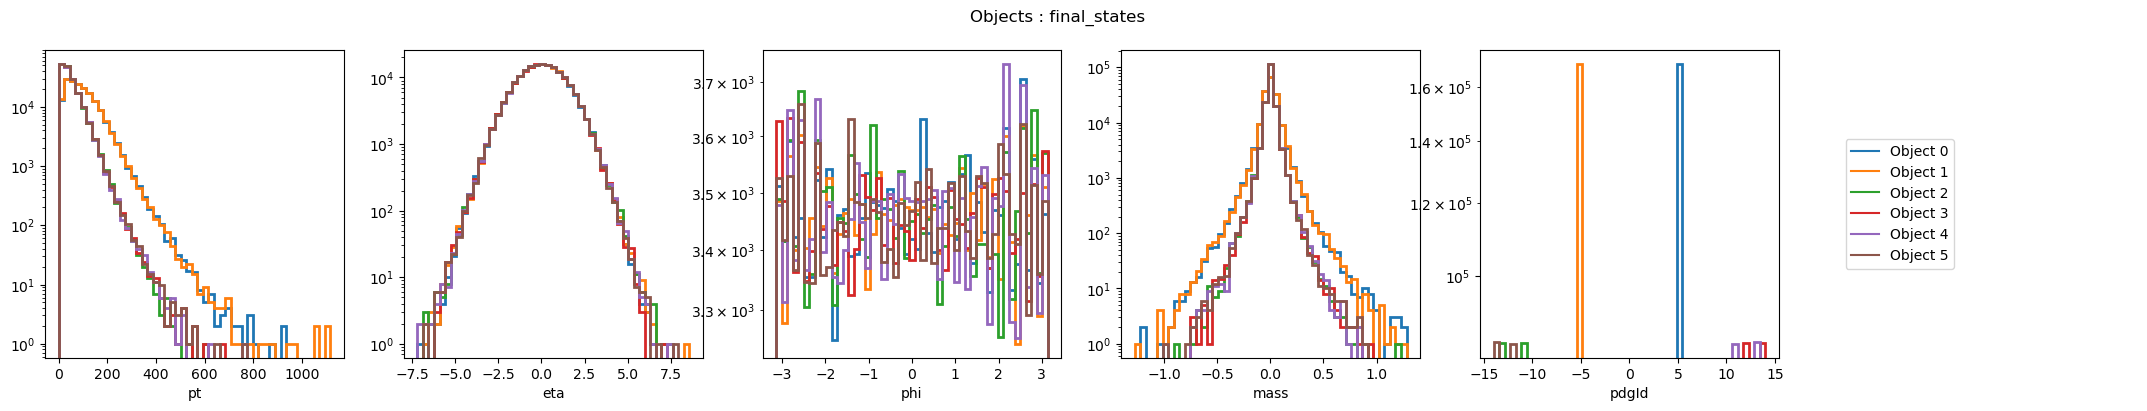

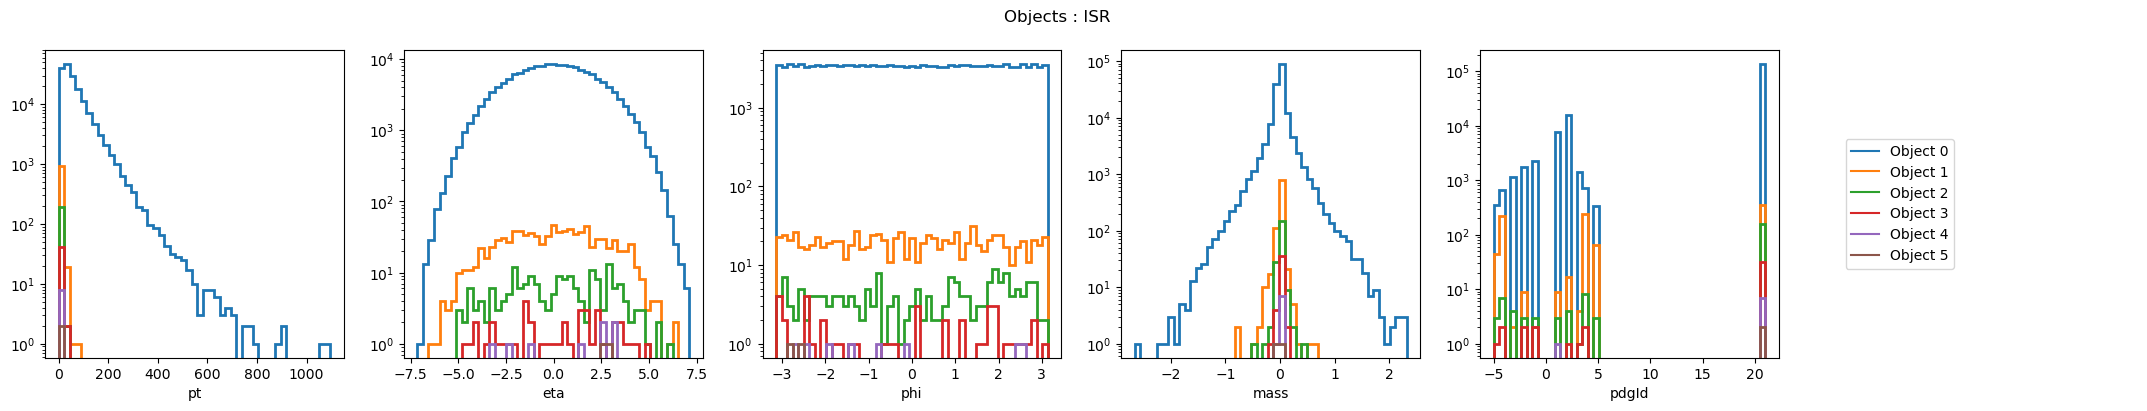

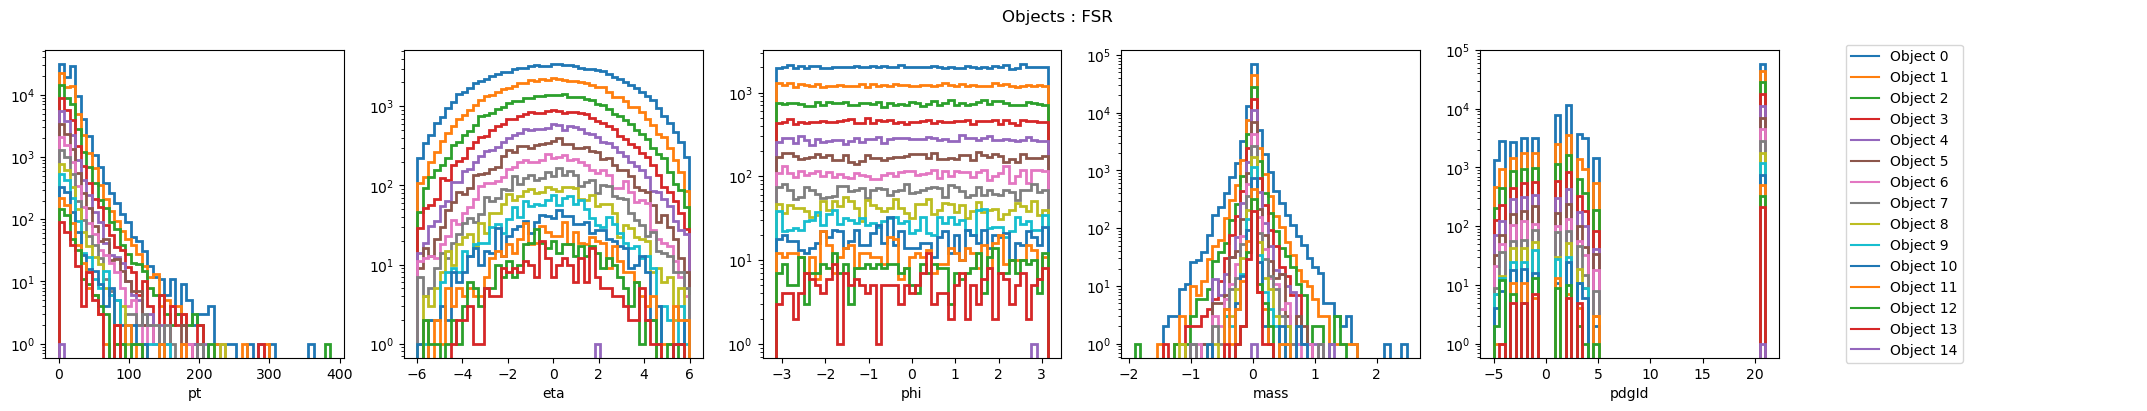

After preprocessing


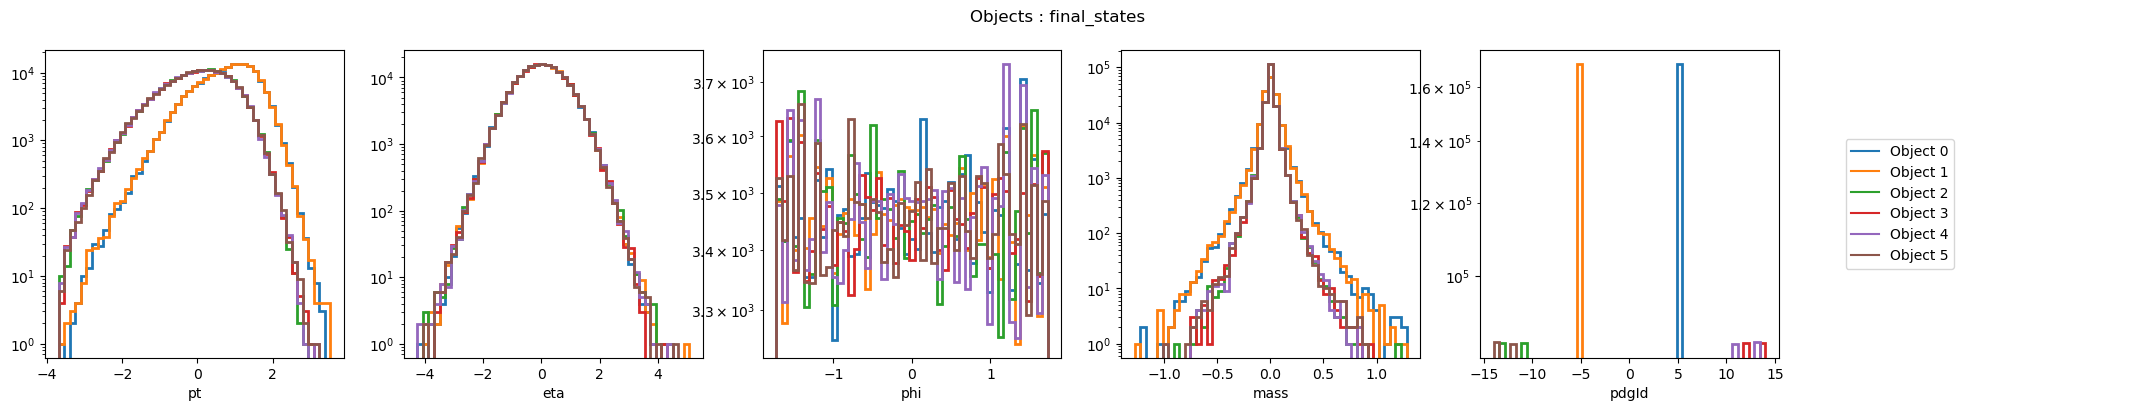

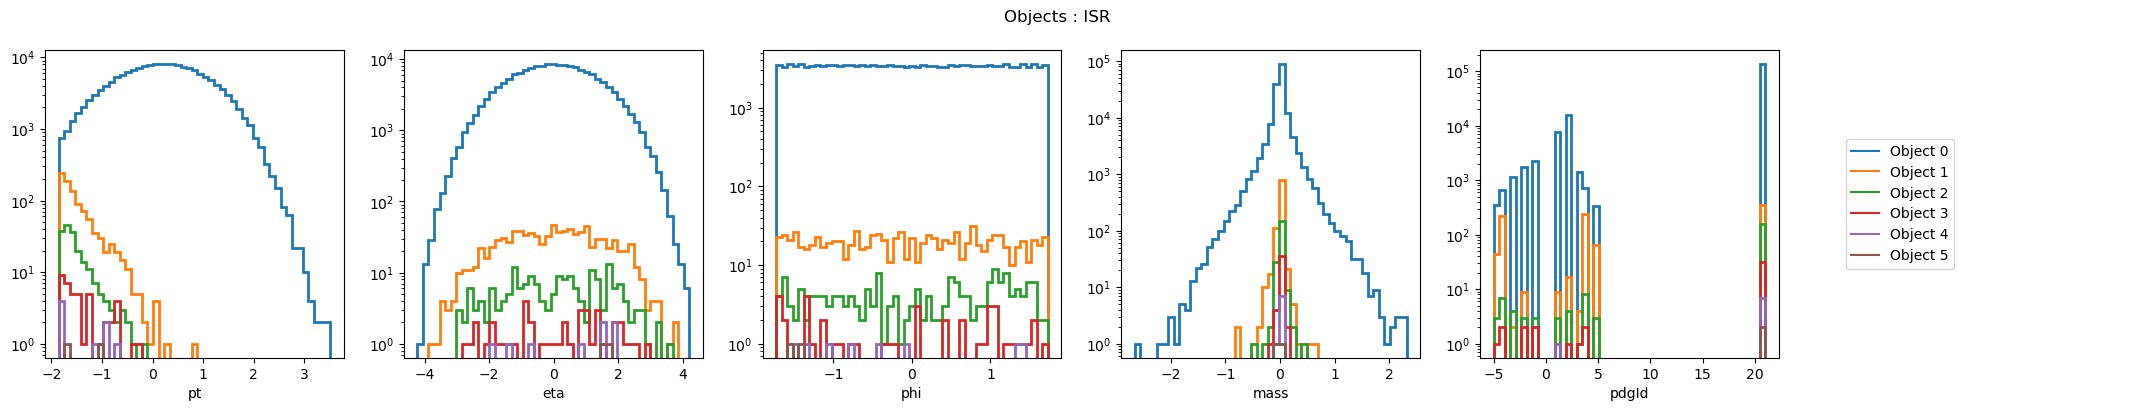

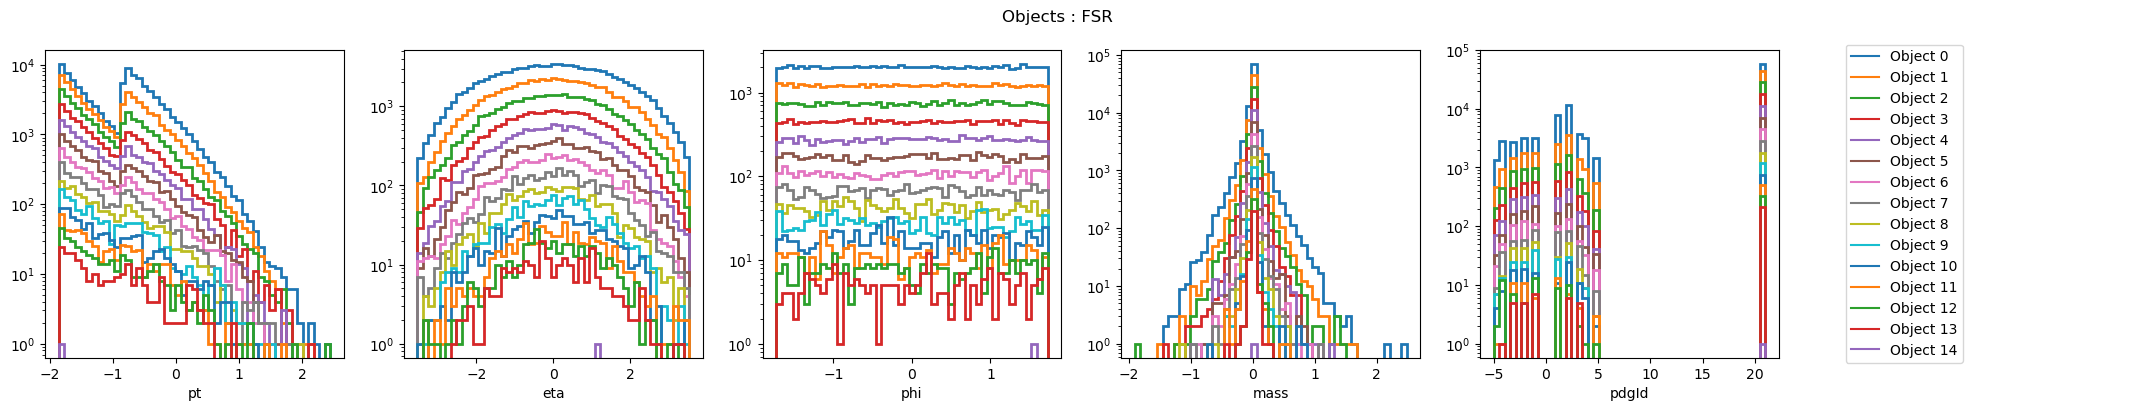

In [48]:
hard_data = RootData(
    files = [
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root',
    ],
    treenames = [
        'gen_HH;1',
    ],
    lazy = True,
    #N = 1000,
)

#print (hard_data)

hard_dataset = HHbbWWDoubleLeptonHardDataset(
    data = hard_data,
    selection = [
        'final_states',
        'ISR',
        'FSR',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print (hard_dataset)

print ('Before preprocessing')
hard_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
hard_dataset.plot(selection=True,raw=False,log=True)

Initial : 396797
Resolved SR : 58664
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/HH/hh_reco
Reco dataset with 58664 events
Containing the following tensors
boost      : data ([58664, 1, 7]), mask ([58664, 1])
             Mask exist    : [100.00%]
             Mask corr     : [True]
             Weights       : 58664.00
             Features      : ['pt', 'eta', 'phi', 'btag', 'pdgId', 'charge', 'mass']
             Selected for batches : False
jets       : data ([58664, 6, 7]), mask ([58664, 6])
             Mask exist    : [100.00%, 100.00%, 55.12%, 22.56%, 7.12%, 1.66%]
             Mask corr     : [True, True, False, False, False, False]
             Weights       : 58664.00, 58664.00, 58664.00, 58664.00, 58664.00, 58664.00
             Features      : ['pt', 'eta', 'phi', 'btag', 'pdgId', 'charge', 'mass']
             Selected for batches : True
electrons  : data ([58664, 2, 7]), mask ([58664, 2])
             Mask exist    : [64.49%, 20.72%]
             M

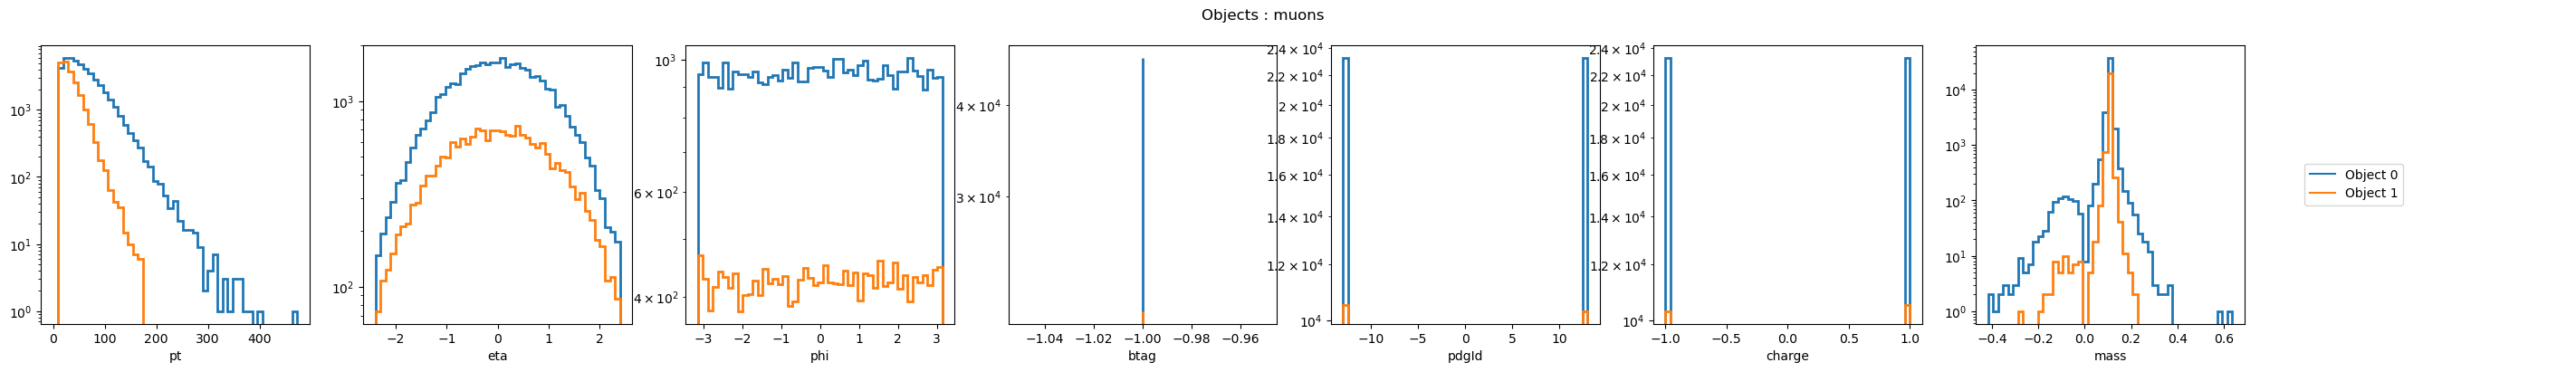

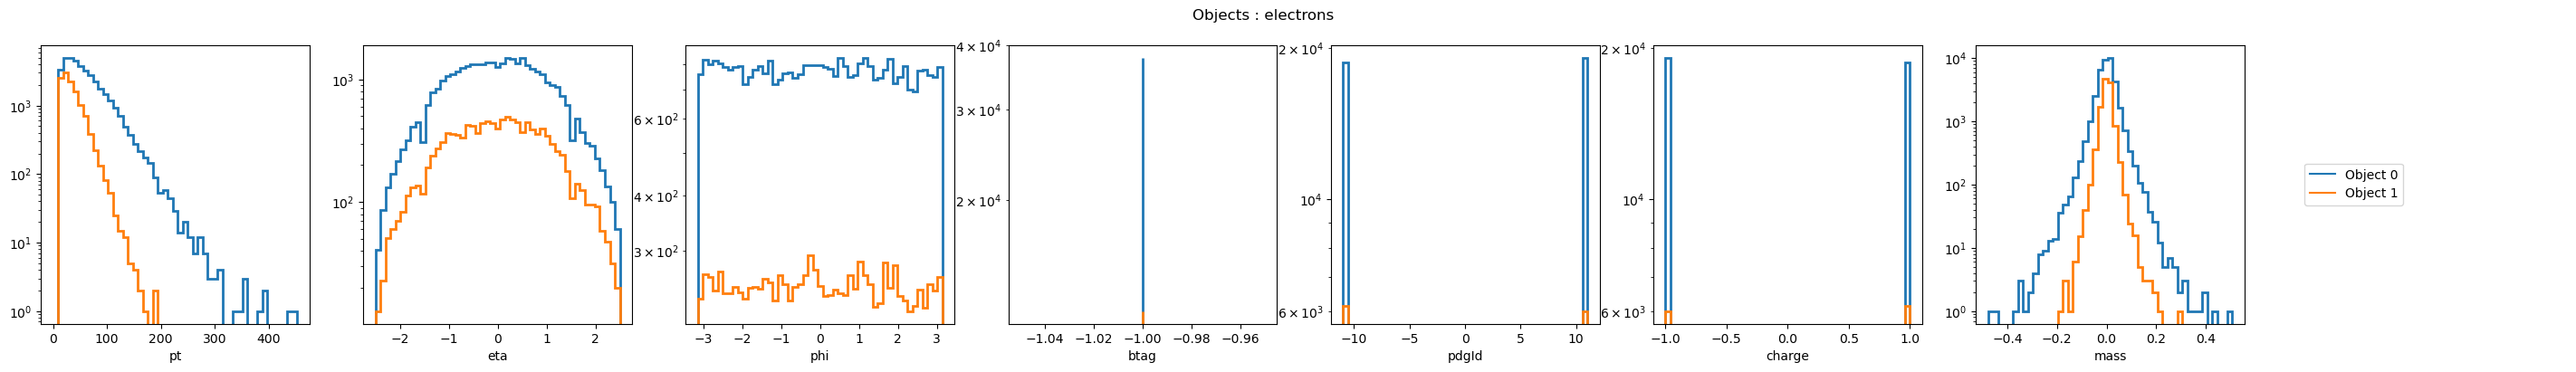

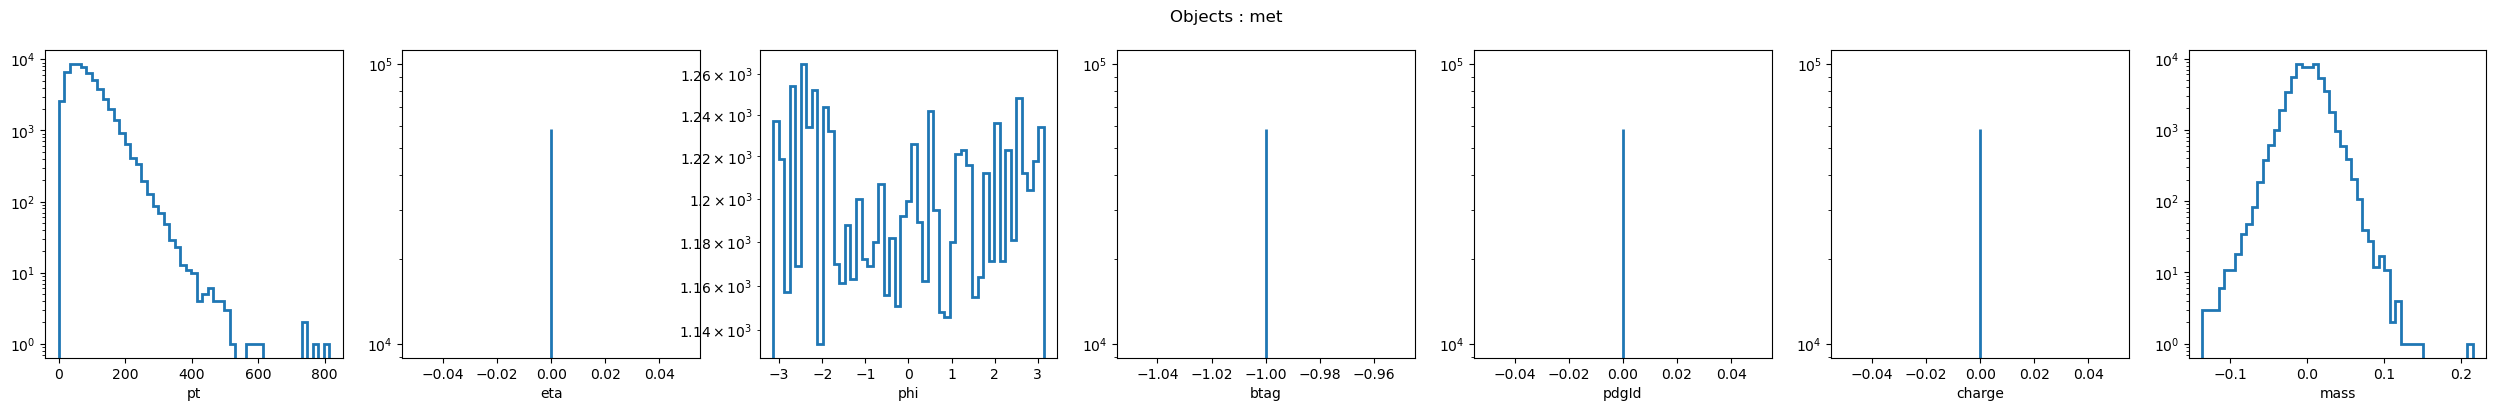

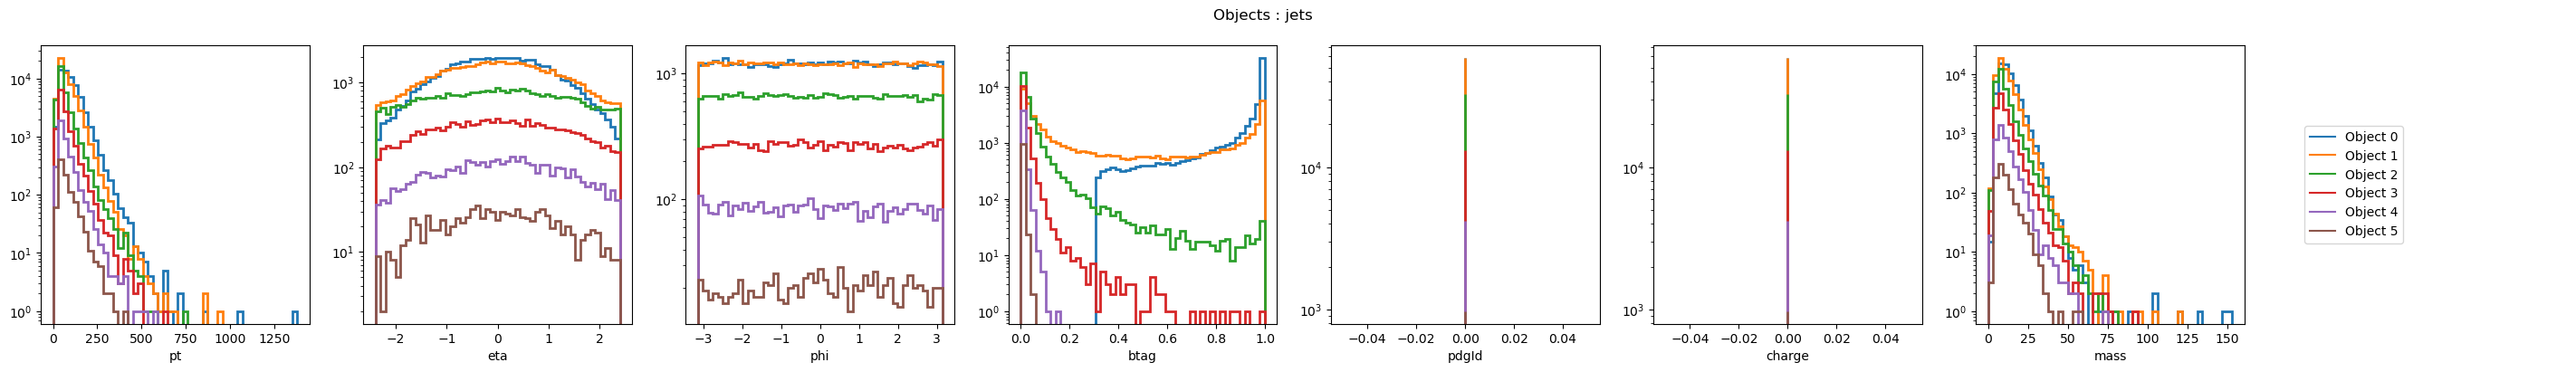

After preprocessing


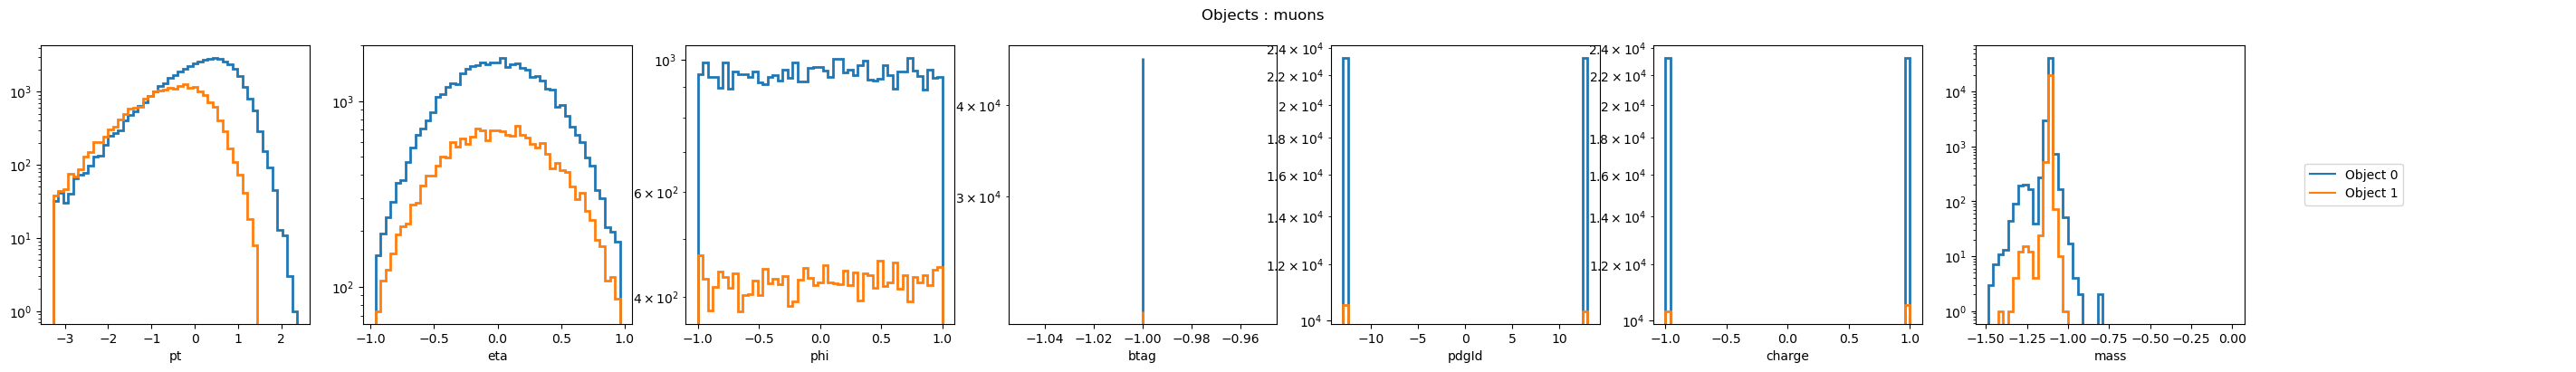

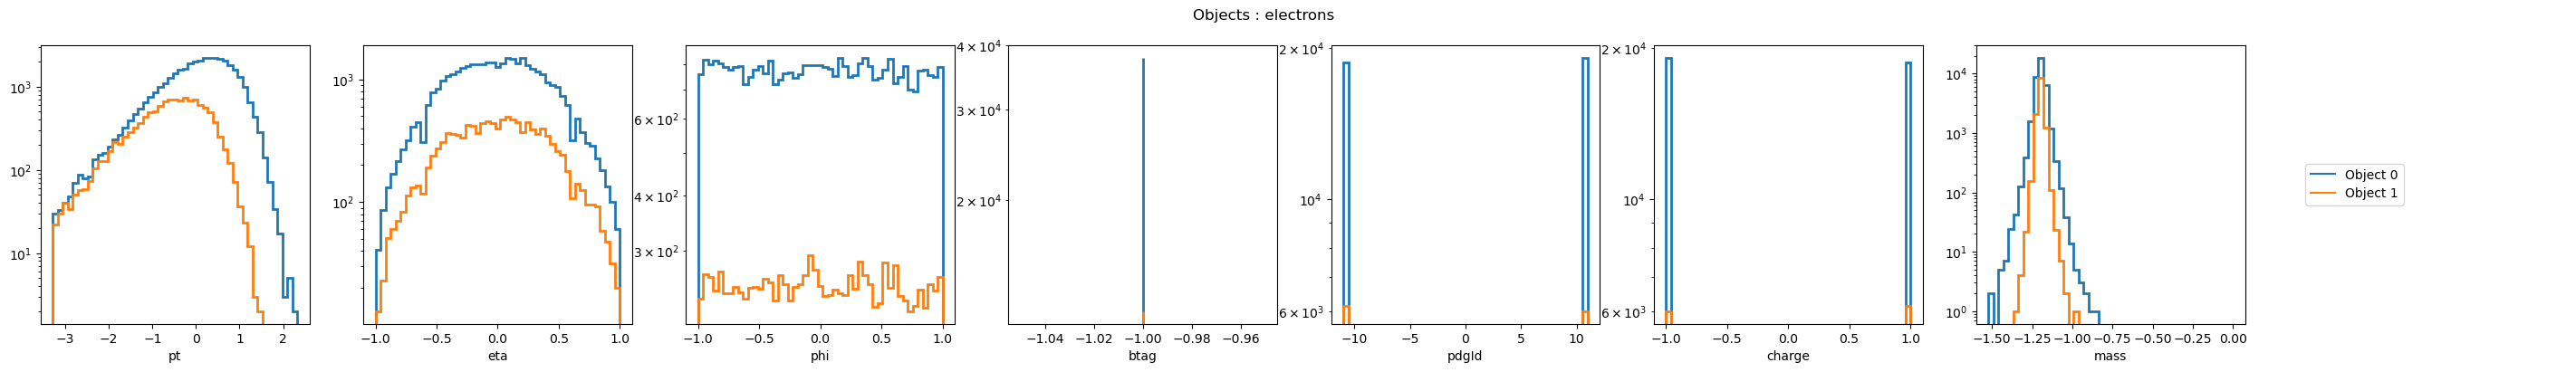

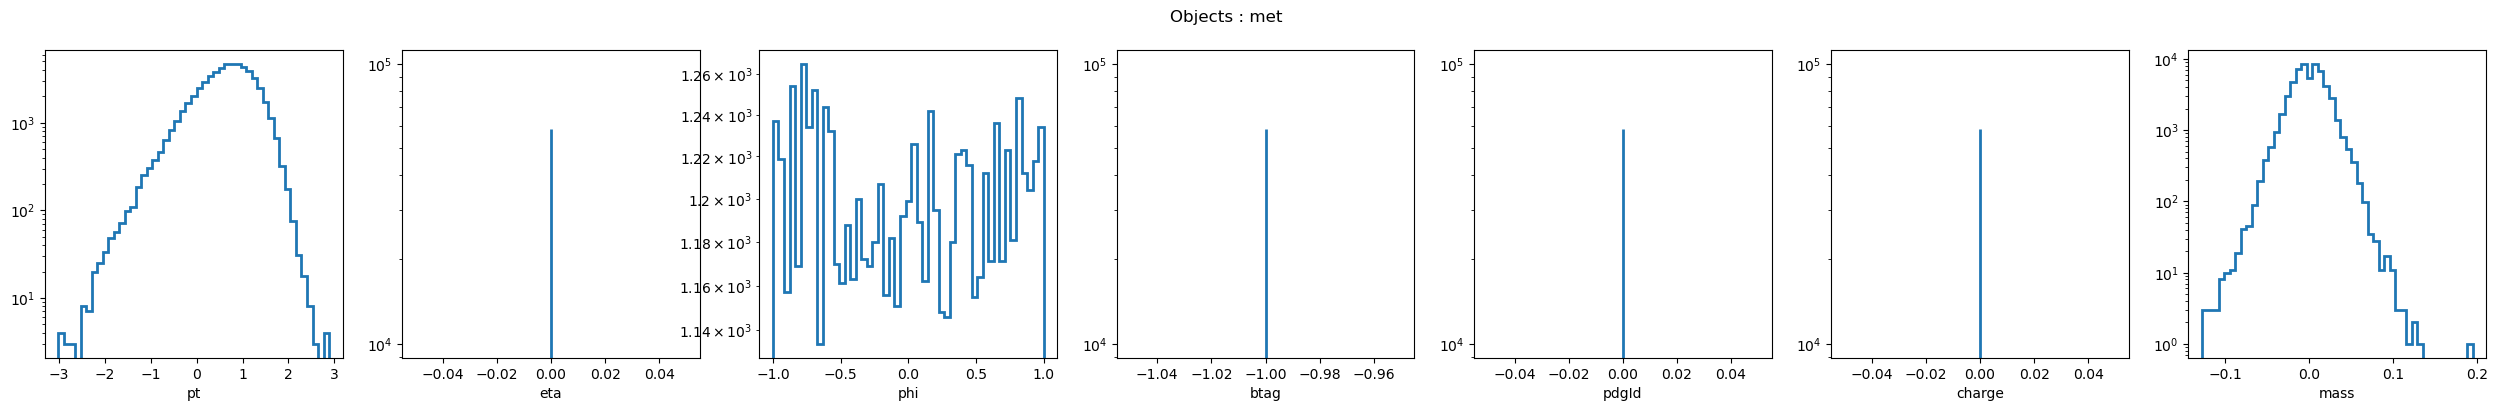

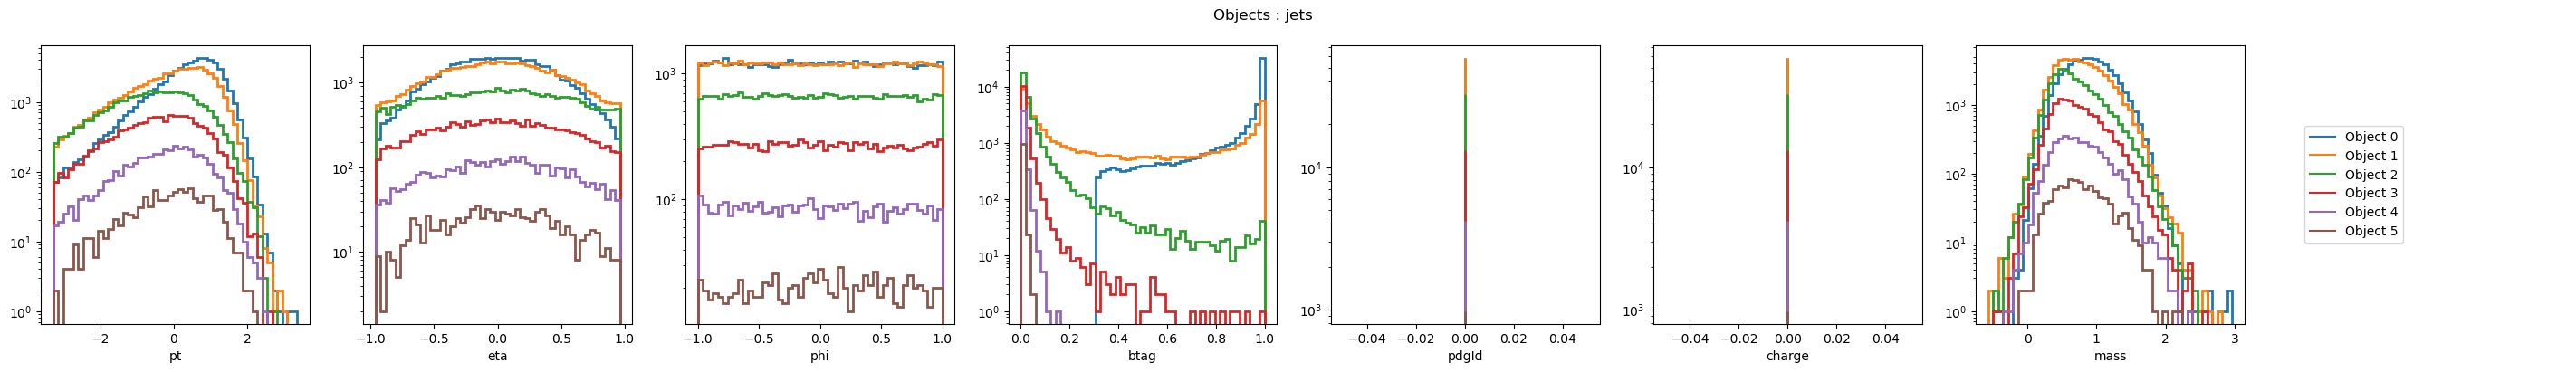

In [38]:
reco_data = RootData(
    files = hard_data.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = hard_data.N,
)
print ('Initial :',reco_data.events)

mask_resolved = np.logical_and.reduce(
    (
        reco_data['flag_SR']==1, 
        reco_data['flag_resolved']==1,
        reco_data['n_AK4']<= 6,
    )
)
reco_data.cut(mask_resolved)
print ('Resolved SR :',reco_data.events)

reco_dataset = HHbbWWDoubleLeptonRecoDataset(
    data = reco_data,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print (reco_dataset)

print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True,weighted=False)
#print ('With weights')
#reco_dataset.plot(selection=True,raw=False,log=True,weighted=True)

In [8]:
comb_dataset = CombinedDataset(
    hard_dataset = hard_dataset,
    reco_dataset = reco_dataset,
    intersection_branch = 'event',
)
print (comb_dataset)

loader_comb = DataLoader(
    comb_dataset,
    batch_size = 256,
)
batch = next(iter(loader_comb))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],reco_dataset.selection):
    print (sel,obj.shape,mask.shape)
print ('Hard')
for obj,mask,sel in zip(batch['Hard']['data'],batch['Hard']['mask'],hard_dataset.selection):
    print (sel,obj.shape,mask.shape)

Looking into file metadata
	entry 0 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root']
	entry 1 : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH0.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH1.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH2p45.root'
 '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu_node_cHHH5.root']
Will only consider common files : ['/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v3/results/GluGluToHHTo2B2VTo2L2Nu

In [10]:
idx_ee = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 2,
    ]
)
idx_mm = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['muons'],axis=1) == 2,
    ]
)
idx_em = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 1,
        ak.count(reco_data['muons'],axis=1) == 1,
    ]
)
for channel,idx in zip(['ee','mm','em'],[idx_ee,idx_mm,idx_em]):
    print (channel)
    for i in idx[:3]:
        event = comb_dataset[i]
        print ('\t idx:',i)
        print ('\t reco: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['reco']['data'],event['reco']['mask']):
            print (f'\t\t{name:15s}',data.shape,mask)
        print ('\t Hard: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['Hard']['data'],event['Hard']['mask']):
            print (f'\t\t{name:15s}')
            print (f'\t\t',data)
            print (f'\t\t',mask)

idx_to_monitor = [idx_ee[0],idx_mm[0],idx_em[0]]
print ('Reco')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['reco']['data'],comb_dataset[idx]['reco']['mask'],comb_dataset.reco_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)
print ('Hard')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['Hard']['data'],comb_dataset[idx]['Hard']['mask'],comb_dataset.hard_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)


ee
	 idx: 10270
	 reco: 
		muons           torch.Size([2, 7]) tensor([0., 0.])
		electrons       torch.Size([2, 7]) tensor([1., 1.])
		met             torch.Size([1, 7]) tensor([1.])
		jets            torch.Size([8, 7]) tensor([1., 1., 1., 1., 1., 1., 1., 1.])
	 gen: 
		muons          
		 tensor([[ 9.5570e-01,  3.9181e-02,  1.6065e+00, -5.1901e-02, -1.1000e+01],
        [ 9.1835e-01, -9.1174e-02, -1.5417e+00, -2.0858e-02,  1.2000e+01],
        [-1.0348e-01, -7.6195e-02,  1.4945e+00,  1.5415e-02,  1.1000e+01],
        [-1.3078e+00, -4.2443e-01, -1.1541e+00,  7.5418e-03, -1.2000e+01]])
		 tensor([1., 1., 1., 1.])
		electrons      
		 tensor([[ 0.7929, -0.4083, -0.5727,  0.0432,  5.0000],
        [-0.4318, -0.7920,  1.4127,  0.0164, -5.0000]])
		 tensor([1., 1.])
	 idx: 12017
	 reco: 
		muons           torch.Size([2, 7]) tensor([0., 0.])
		electrons       torch.Size([2, 7]) tensor([1., 1.])
		met             torch.Size([1, 7]) tensor([1.])
		jets            torch.Size([8, 7]) tensor([1., 

In [11]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.9
indices = torch.arange(len(comb_dataset))
sep = int(train_frac*len(comb_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

comb_dataset_train = torch.utils.data.Subset(comb_dataset,train_indices)
comb_dataset_valid = torch.utils.data.Subset(comb_dataset,valid_indices)
print (len(comb_dataset_train),len(comb_dataset_valid))

batch_size = 1024

loader_comb_train = DataLoader(
    comb_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_comb_valid = DataLoader(
    comb_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

187619 20847


In [12]:
from memflow.models.transfer_flow_model import TransferFlow

model = TransferFlow(
    # Harderal args #
    dropout = 0.,
    # Embedding arguments #
    embed_dims = [32,64],
    embed_act = nn.GELU,
    # Particle features, names, masks, and number for printouts and logging #
    n_hard_particles_per_type = hard_dataset.number_particles_per_type,
    hard_particle_type_names = hard_dataset.selection,
    hard_input_features_per_type = hard_dataset.input_features,
    n_reco_particles_per_type = reco_dataset.number_particles_per_type,
    reco_particle_type_names = reco_dataset.selection,
    reco_input_features_per_type = reco_dataset.input_features,
    flow_input_features = [ # features to be used in the flows (different from the tranformer)
        ['pt','eta','phi'], # electrons
        ['pt','eta','phi'], # muons
        ['pt','phi'],       # met
        ['pt','eta','phi'], # jets
    ],
    reco_mask_corr = reco_dataset.correlation_mask,
    hard_mask_corr = hard_dataset.correlation_mask,
    # Transformer arguments #
    onehot_encoding = True, # add onehot encoded position vector to features
    transformer_args = { # to be passed to the Transformer pytorch class
        'nhead' : 8,
        'num_encoder_layers' : 8, 
        'num_decoder_layers' : 8, 
        'dim_feedforward' : 128, 
        'dropout' : 0., 
        'activation' : 'gelu', 
    },
    # Flow args #
    flow_common_args = { # common args for all flows
        'bins' : 8,
        'transforms' : 5,
        'randperm' : True,
        'passes' : None,
        'hidden_features' : [128] * 3,   
    },
    flow_classes = { # classes for each feature
        'pt'  : zuko.flows.NSF,
        'eta' : UniformNSF,
        'phi' : UniformNCSF,
        'pt'  : zuko.flows.NSF,
    },
    flow_specific_args = { # specific args for each class above
        'eta' : {'bound' : 1.},
        'phi' : {'bound' : 1.},
    },
    flow_mode = 'global', # 'global', 'type' or 'particle'
)
model = model.cpu()

batch = next(iter(loader_comb))
log_probs, mask, weights = model(batch)
print ('log_probs',log_probs,log_probs.shape)
print ('mask',mask,mask.shape)
print ('weights',weights,weights.shape)

log_probs_tot = model.shared_eval(batch,0,'test')
print ('tot log probs',log_probs_tot)

samples = model.sample(batch['Hard']['data'],batch['Hard']['mask'],batch['reco']['data'],batch['reco']['mask'],N=100)
print ('samples')
for sample in samples:
    print ('\t',sample.shape)

print (model)


/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/zuko/transforms.py:494: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/BucketizationUtils.h:32.)
  return torch.searchsorted(seq, value).squeeze(dim=-1)


log_probs tensor([[3.9569, 2.7383, 3.0751,  ..., 2.7328, 2.7318, 2.7310],
        [2.2031, 2.1876, 2.7160,  ..., 2.7231, 2.7215, 2.7201],
        [2.3101, 2.7775, 3.2005,  ..., 2.7425, 2.7384, 2.7353],
        ...,
        [3.7208, 2.7505, 2.1881,  ..., 2.7177, 2.7153, 2.7131],
        [2.8119, 2.7659, 1.8393,  ..., 2.7420, 2.7395, 2.7374],
        [2.5442, 2.8376, 2.7359,  ..., 2.7481, 2.7478, 2.7468]],
       grad_fn=<NegBackward0>) torch.Size([256, 13])
mask tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]]) torch.Size([256, 13])
weights tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tot log probs tensor(2.8608, grad_fn=<MeanBackward0>)
samples
	 torch.Size([100, 256, 2, 3])
	 torch.Size([100, 256, 2, 3])
	 torch.Size([100, 256, 1, 2])
	 torch.Size([100, 256, 8, 3])
TransferFlow(
  (gen_embeddings): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): GELU(approximate='none')
    )
  )
  (reco_embeddings): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=21, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): GELU(approximate='none')
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, b

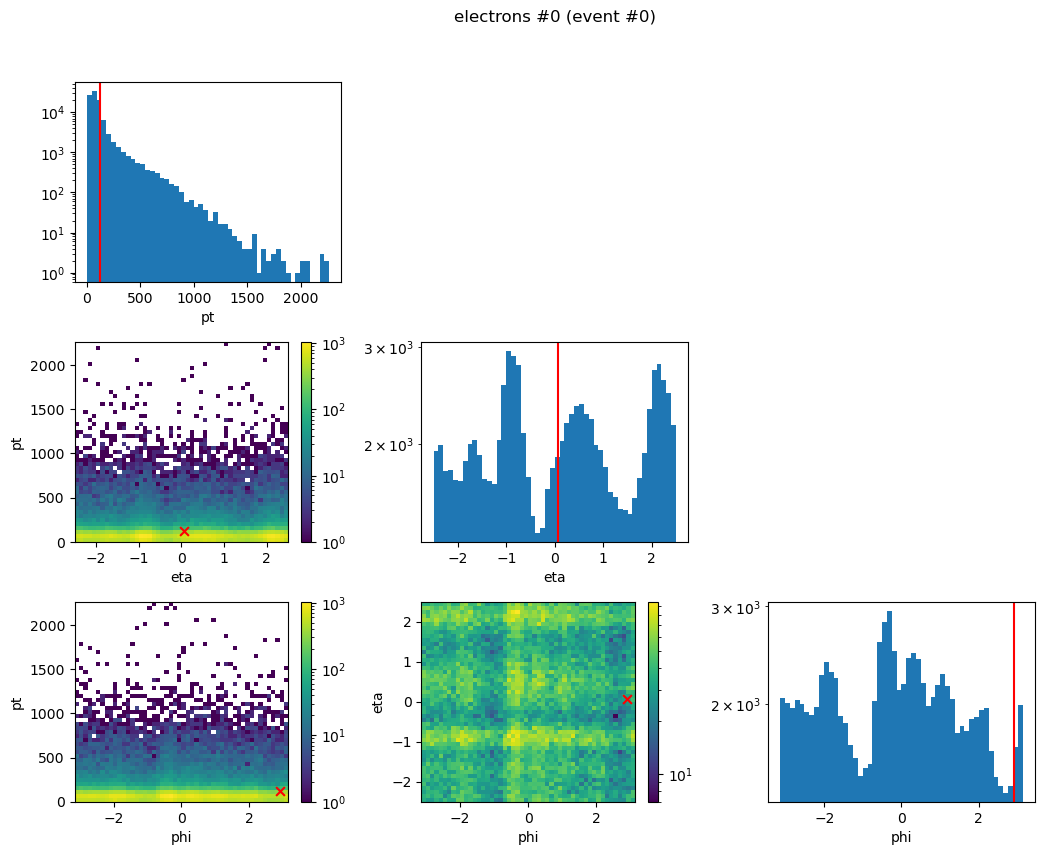

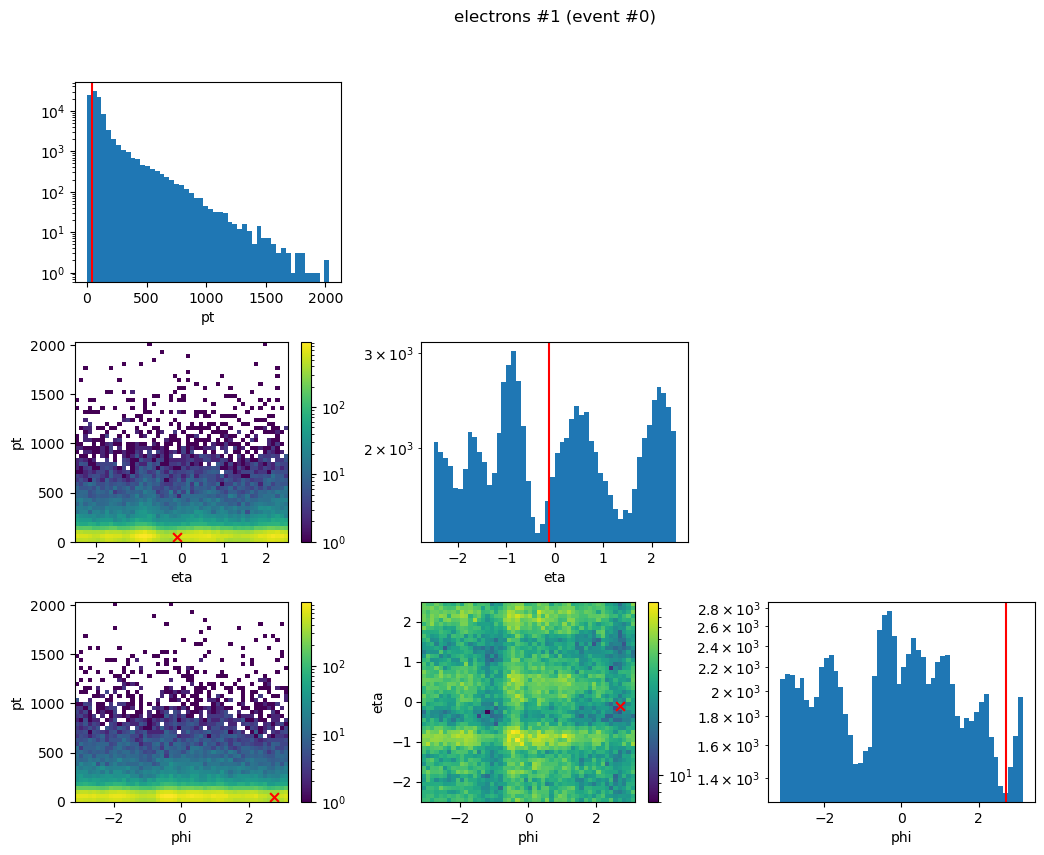

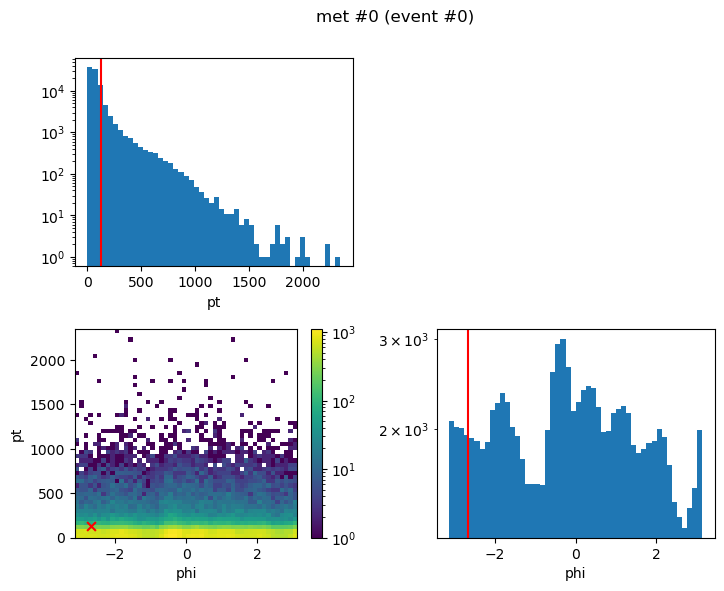

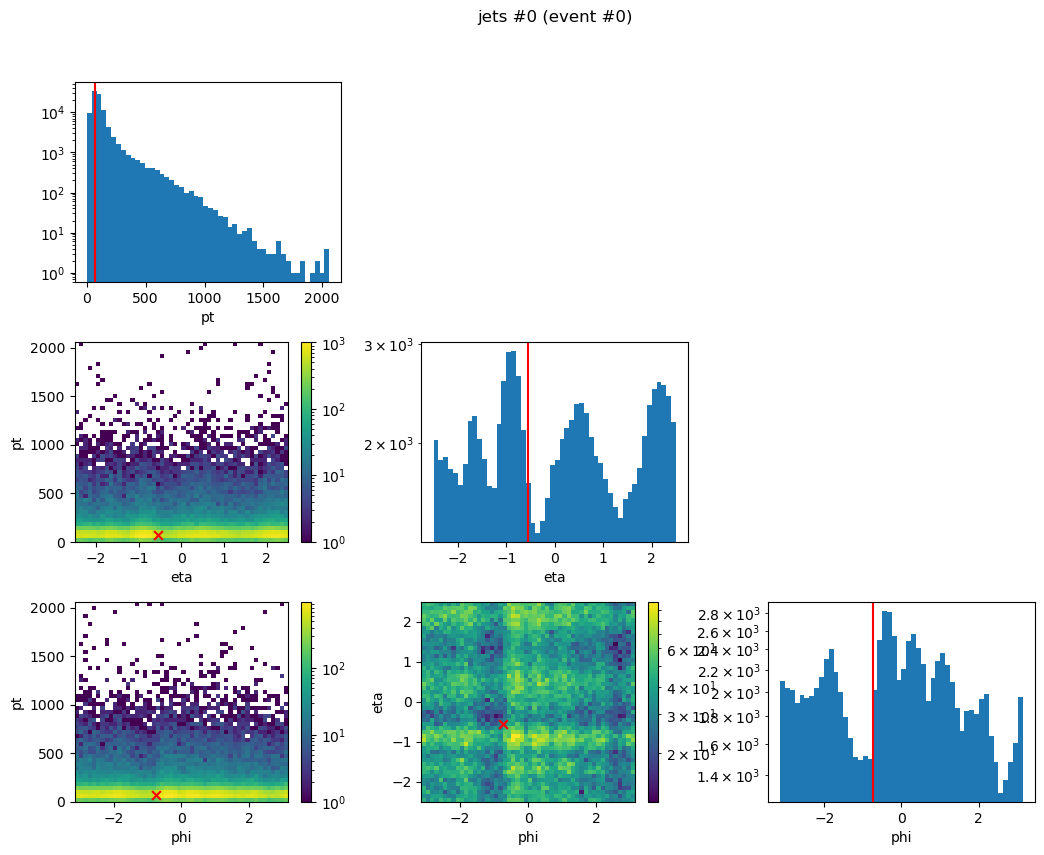

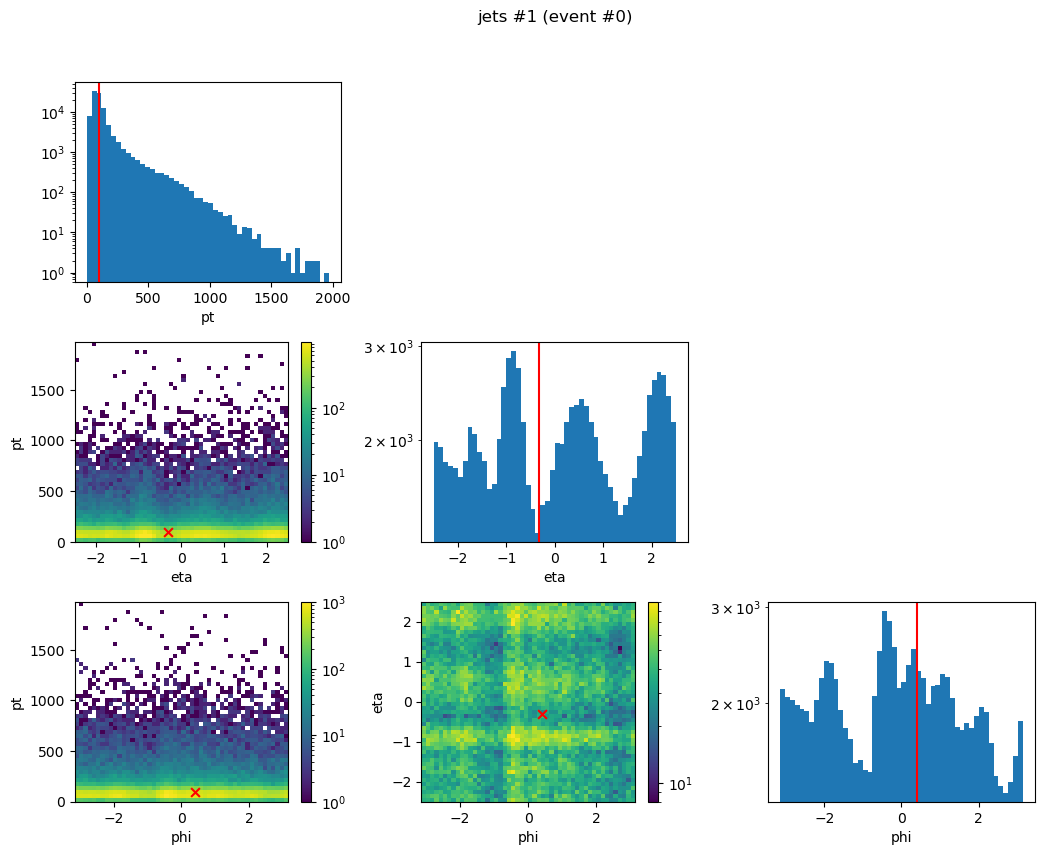

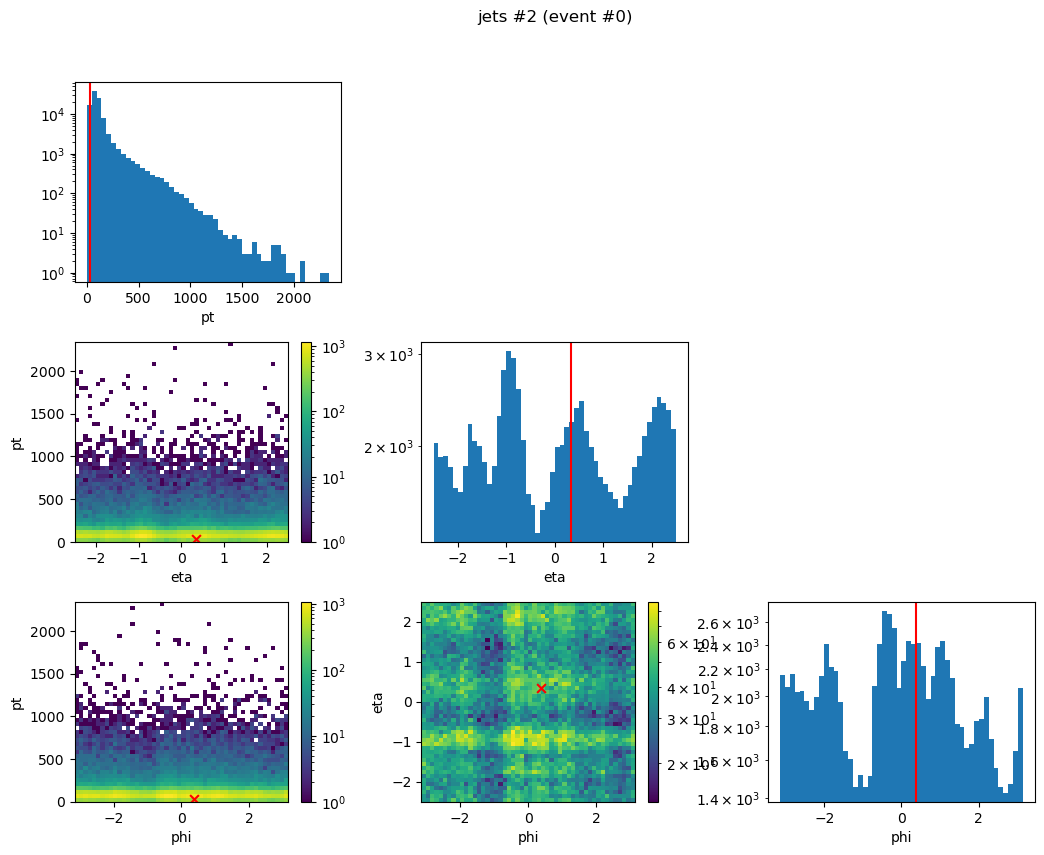

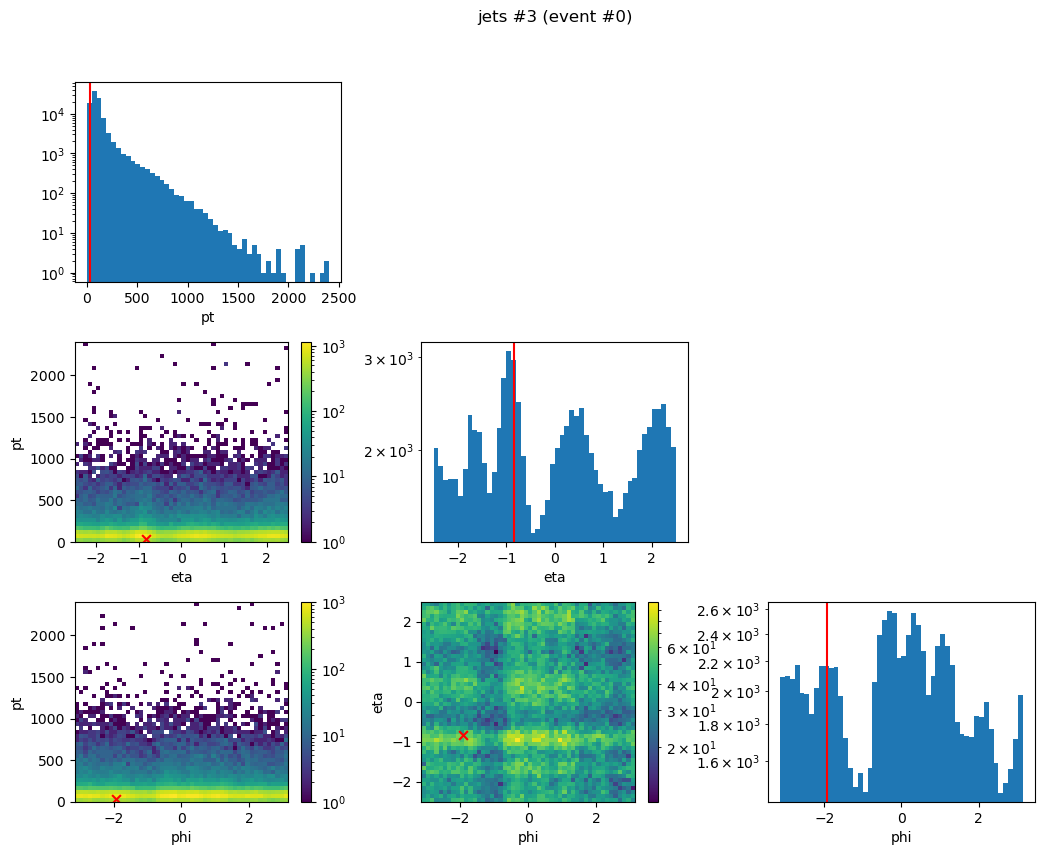

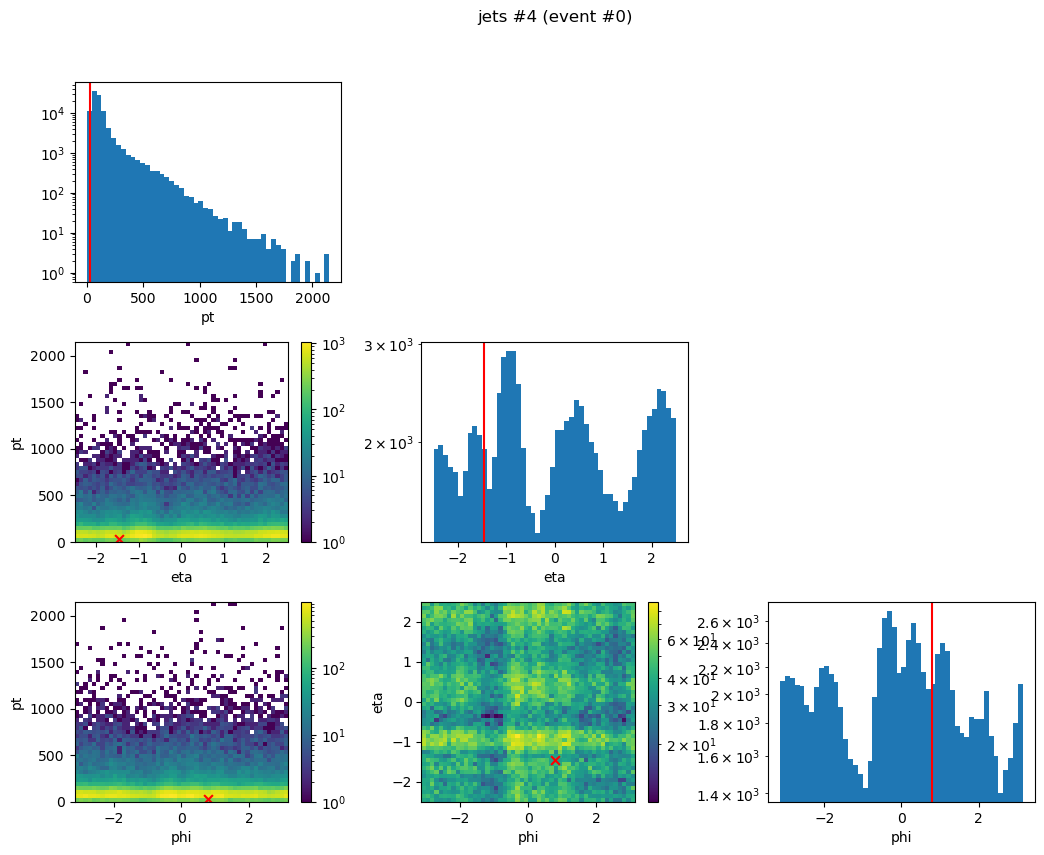

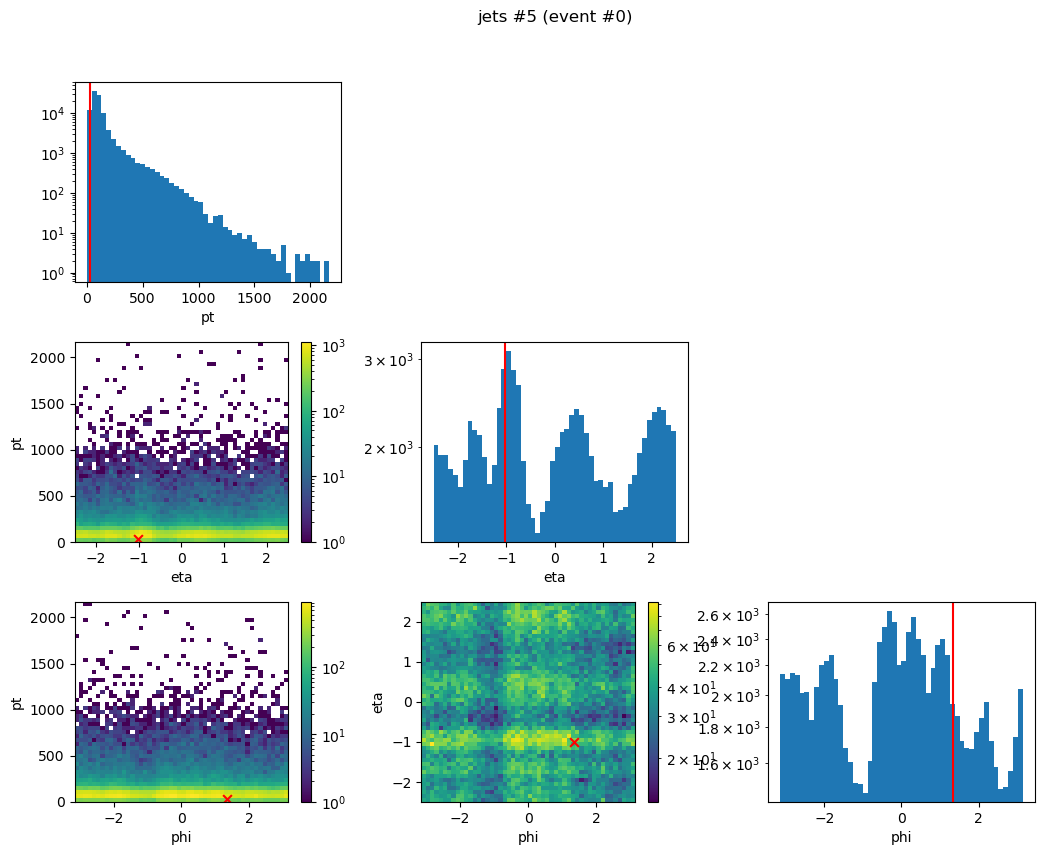

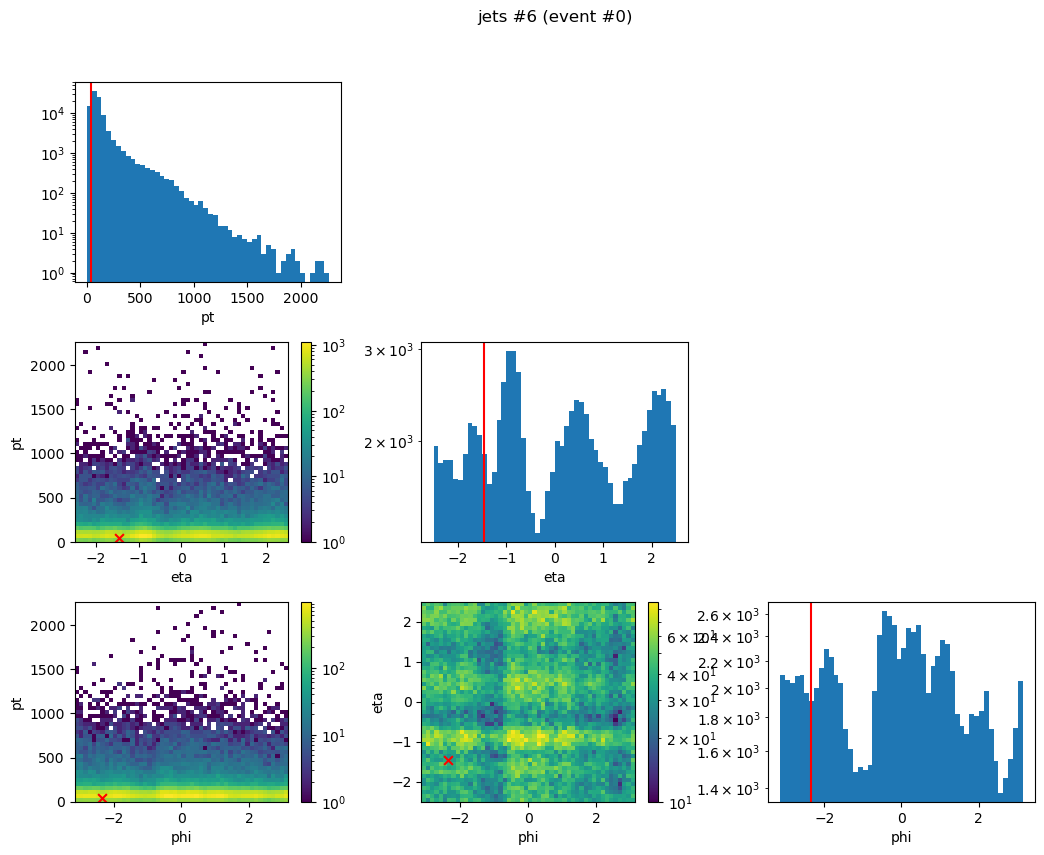

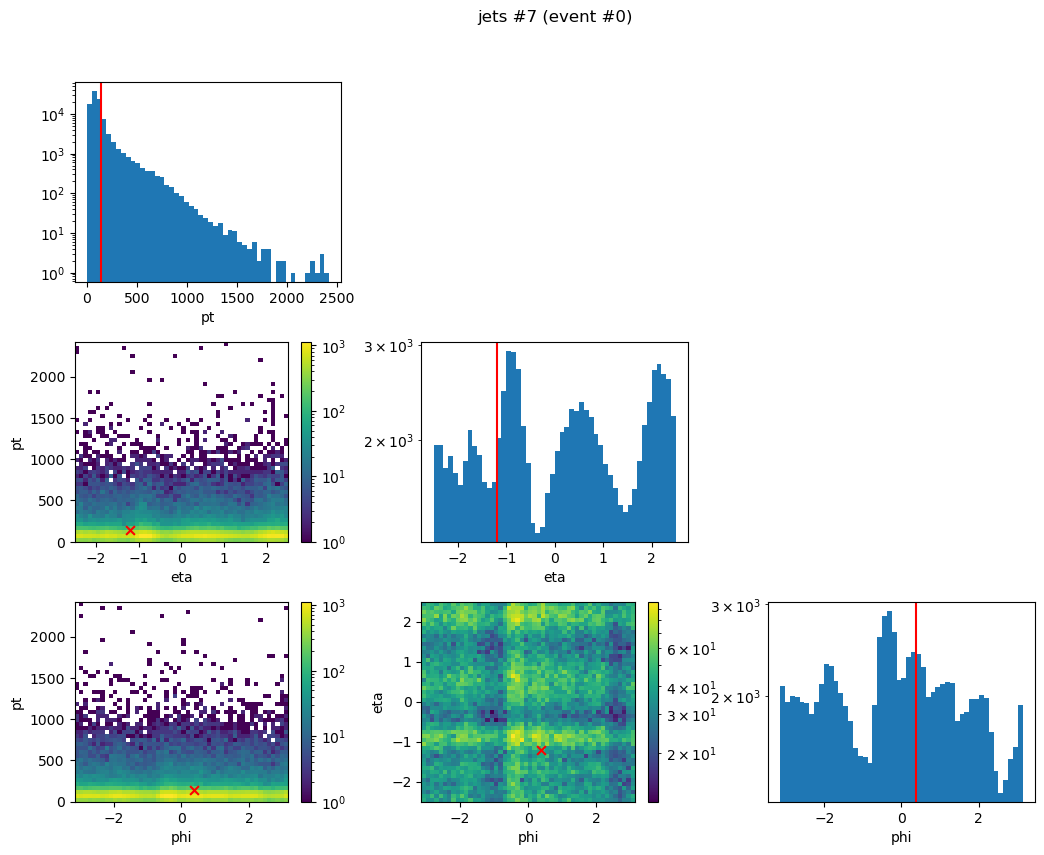

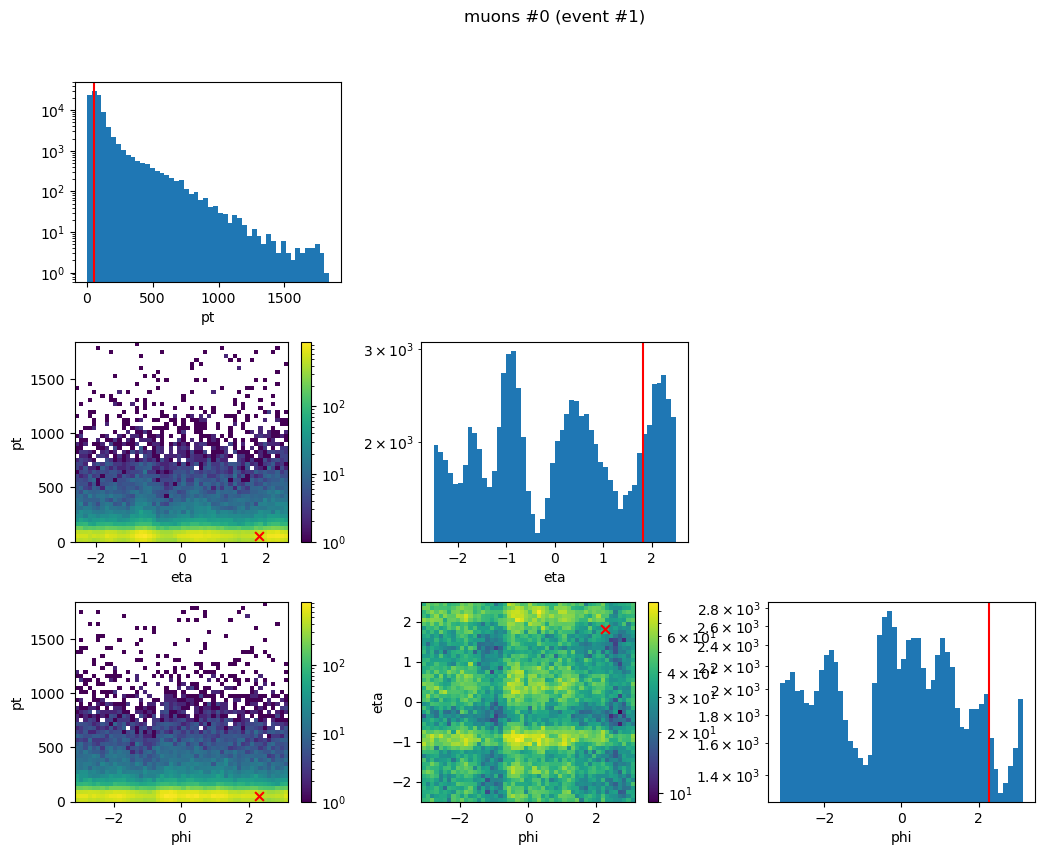

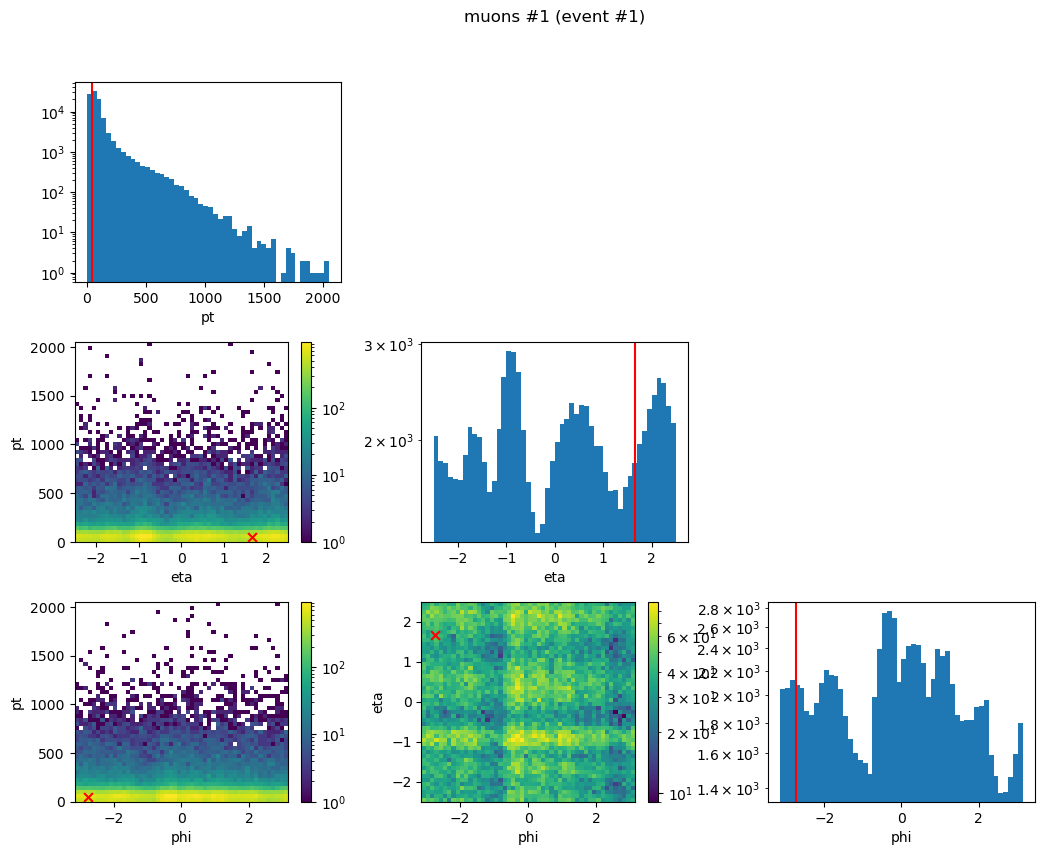

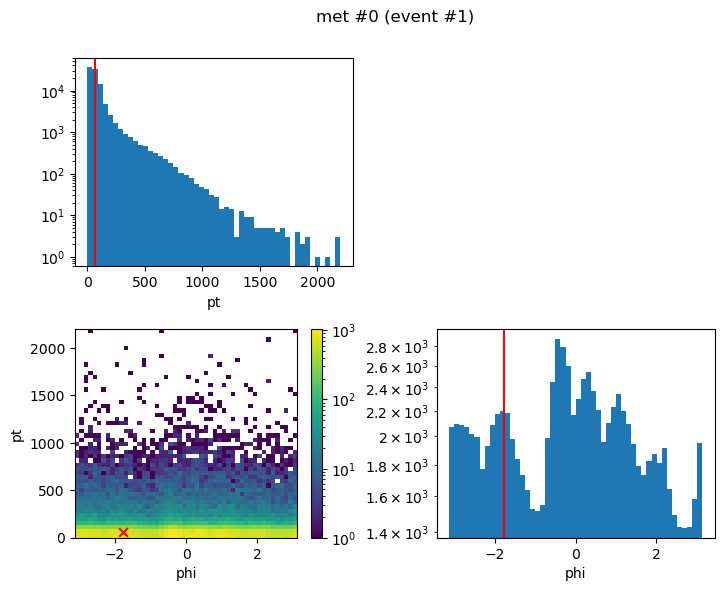

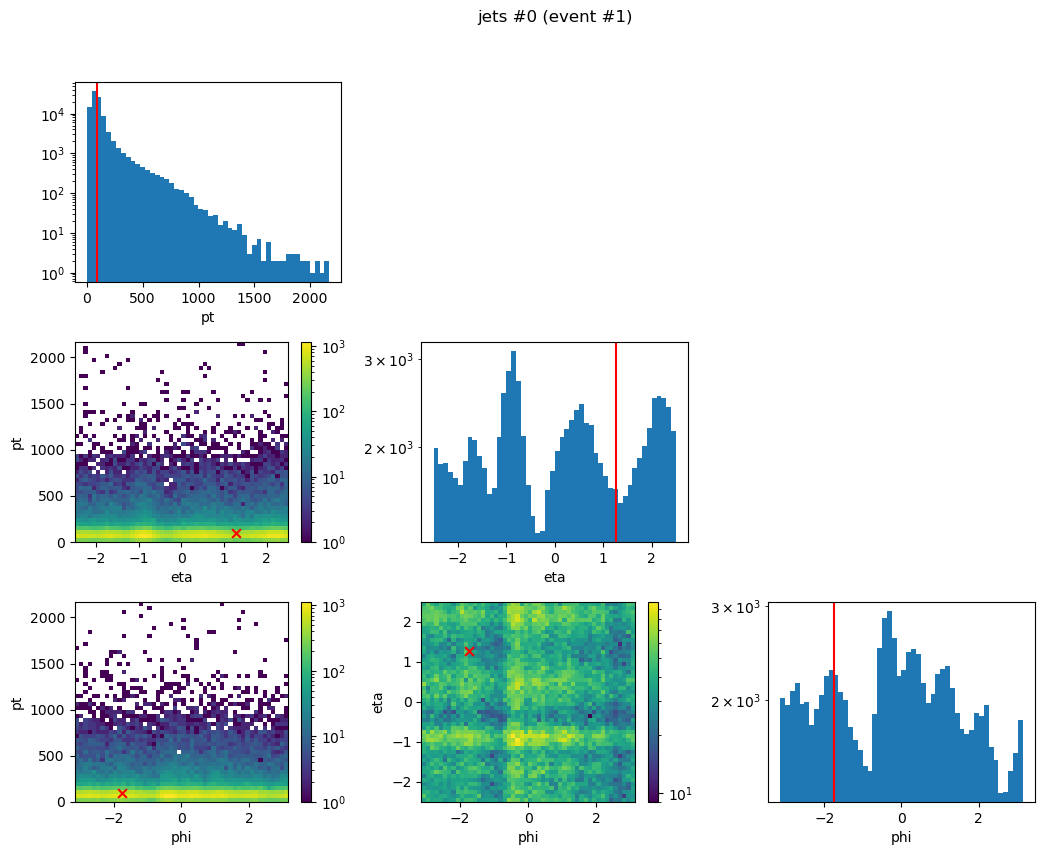

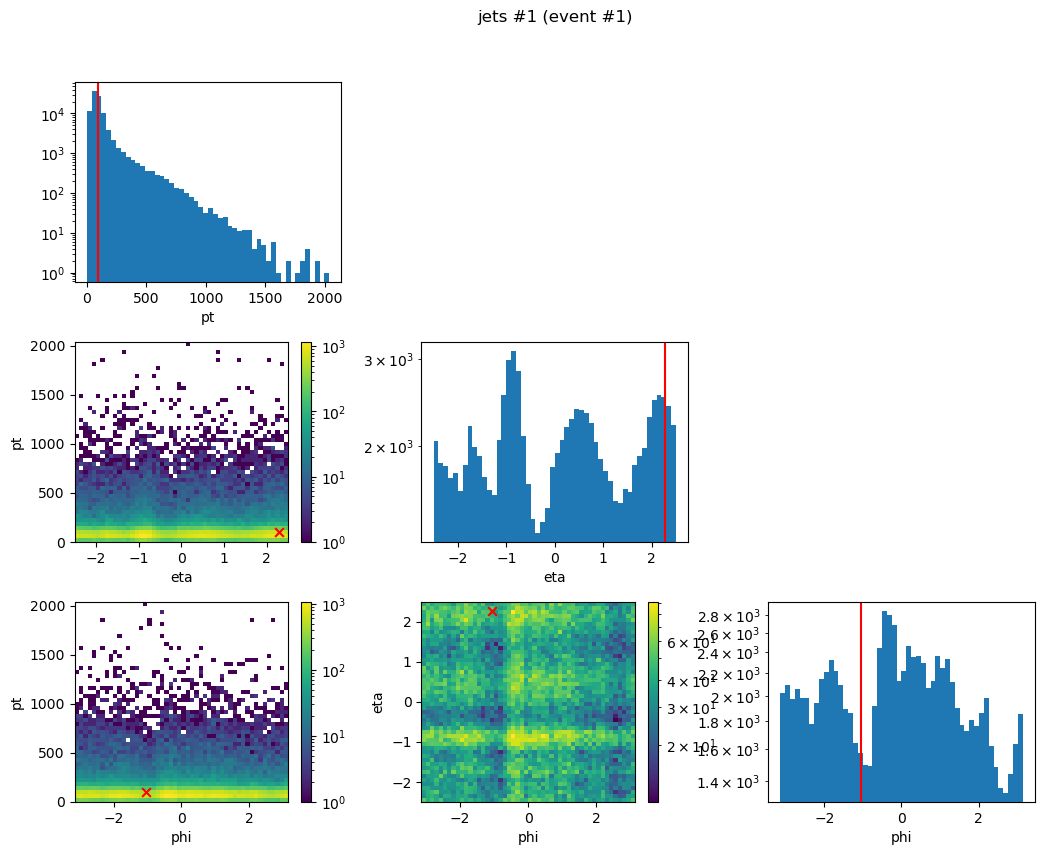

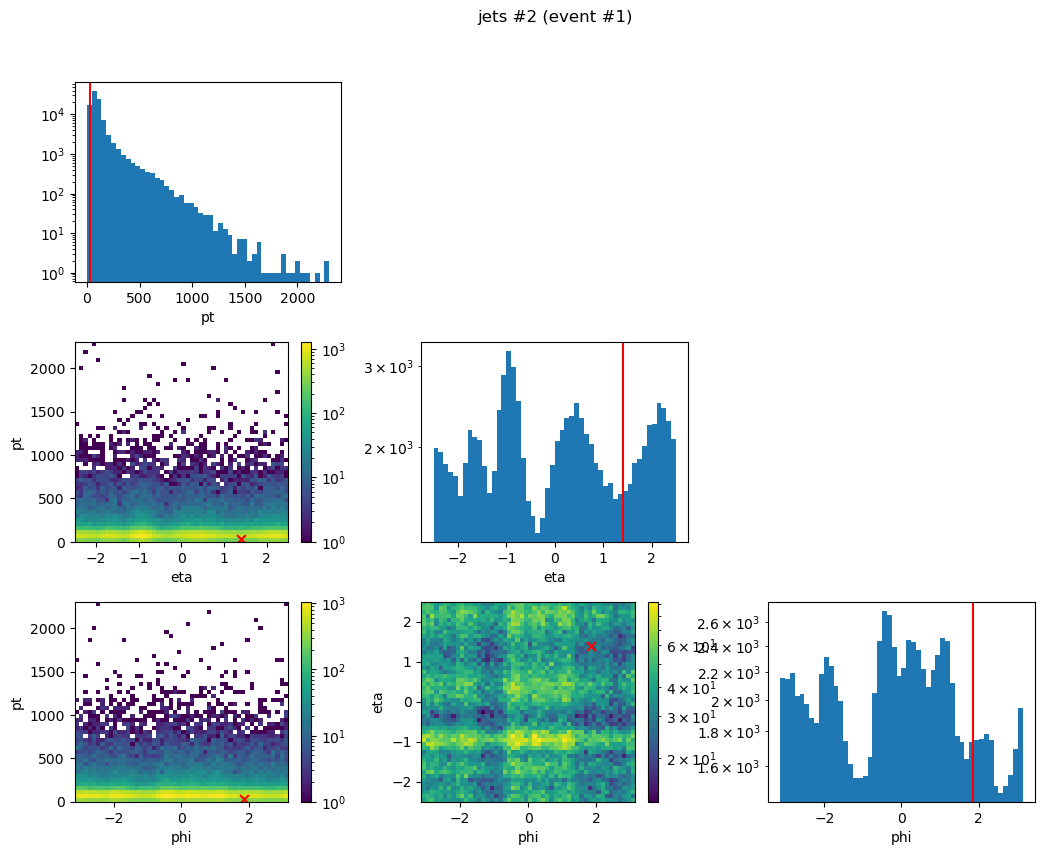

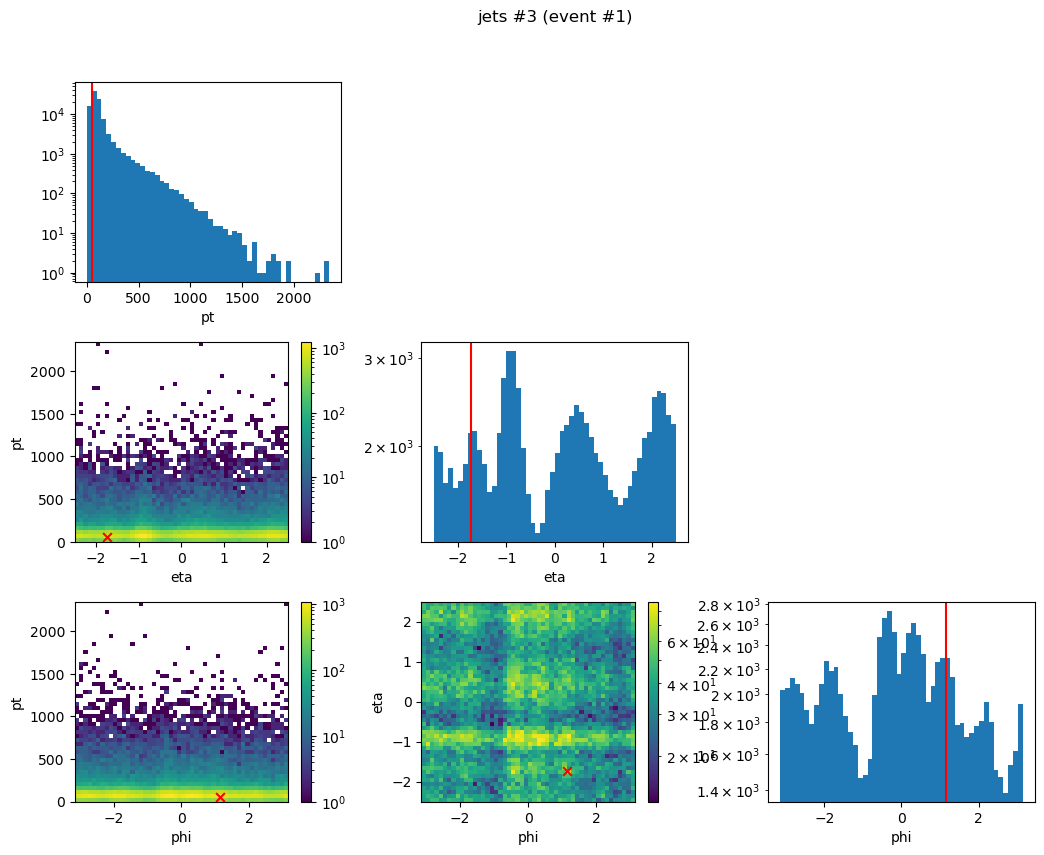

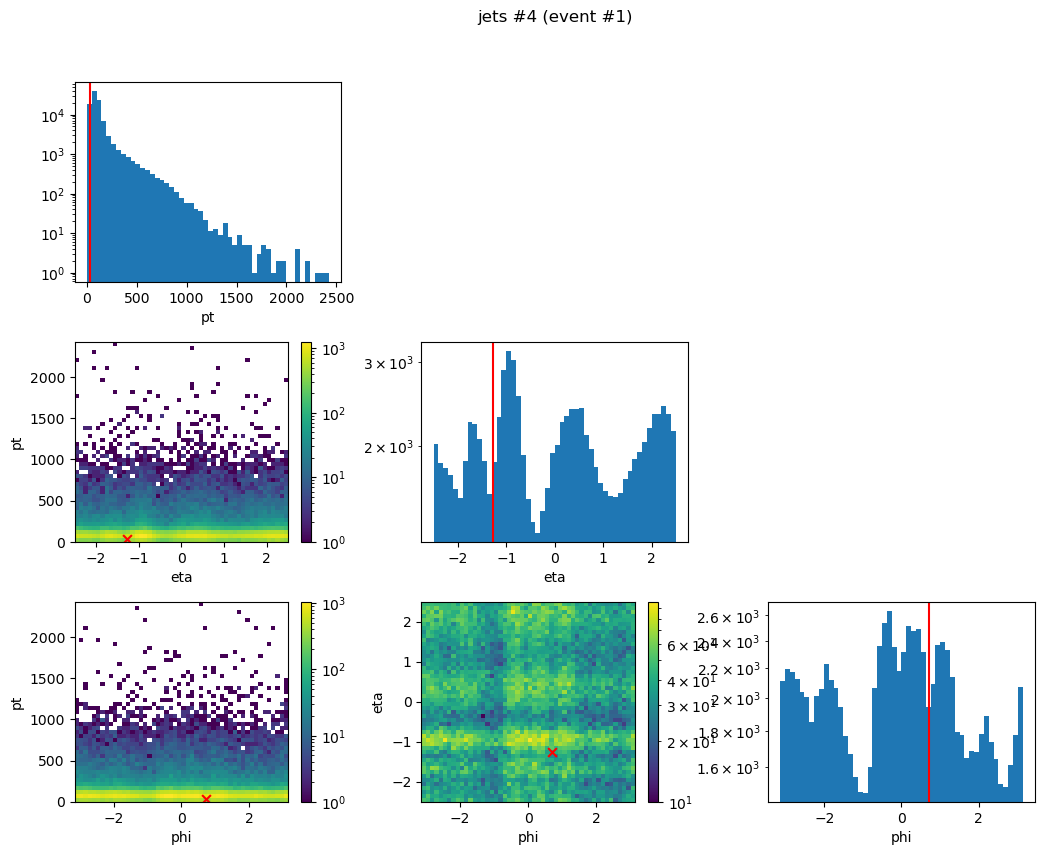

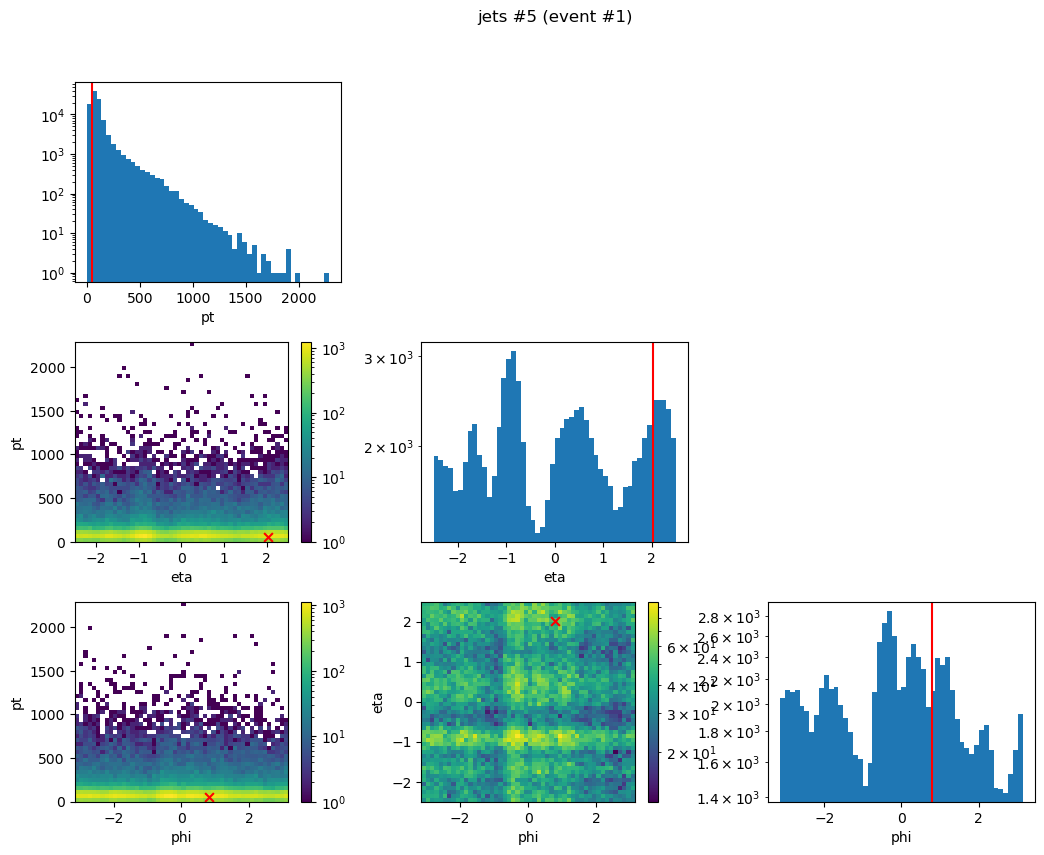

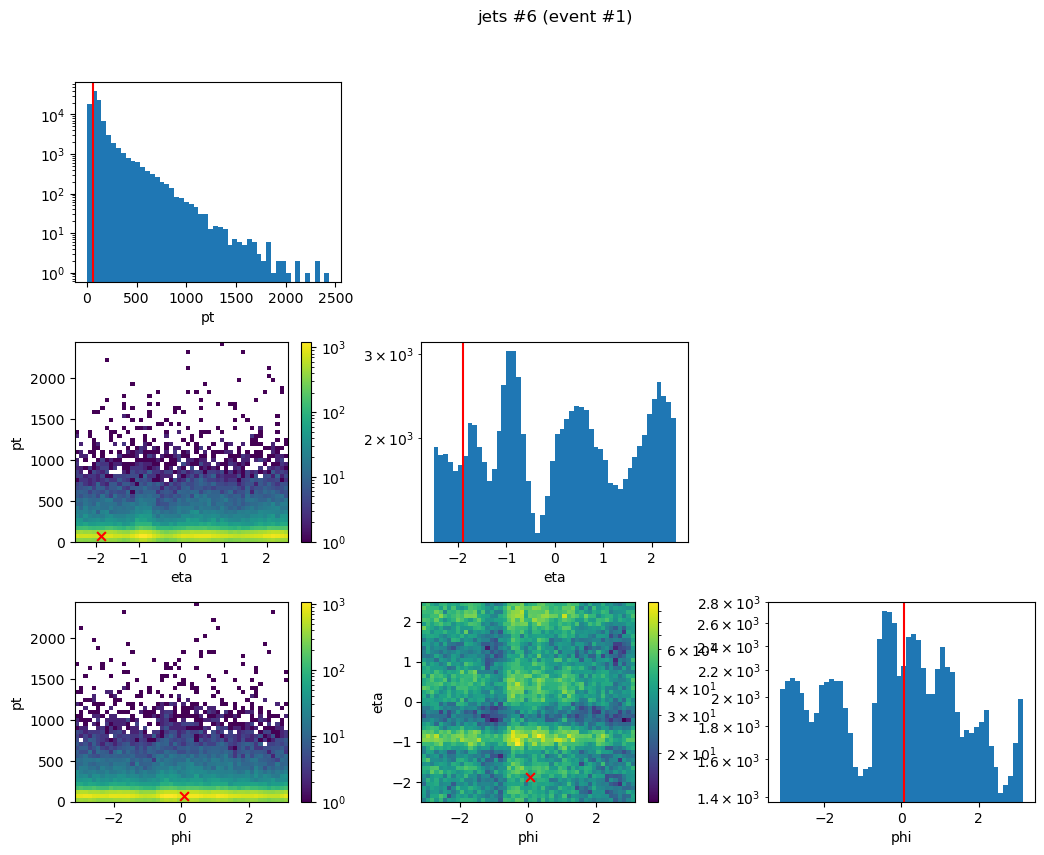

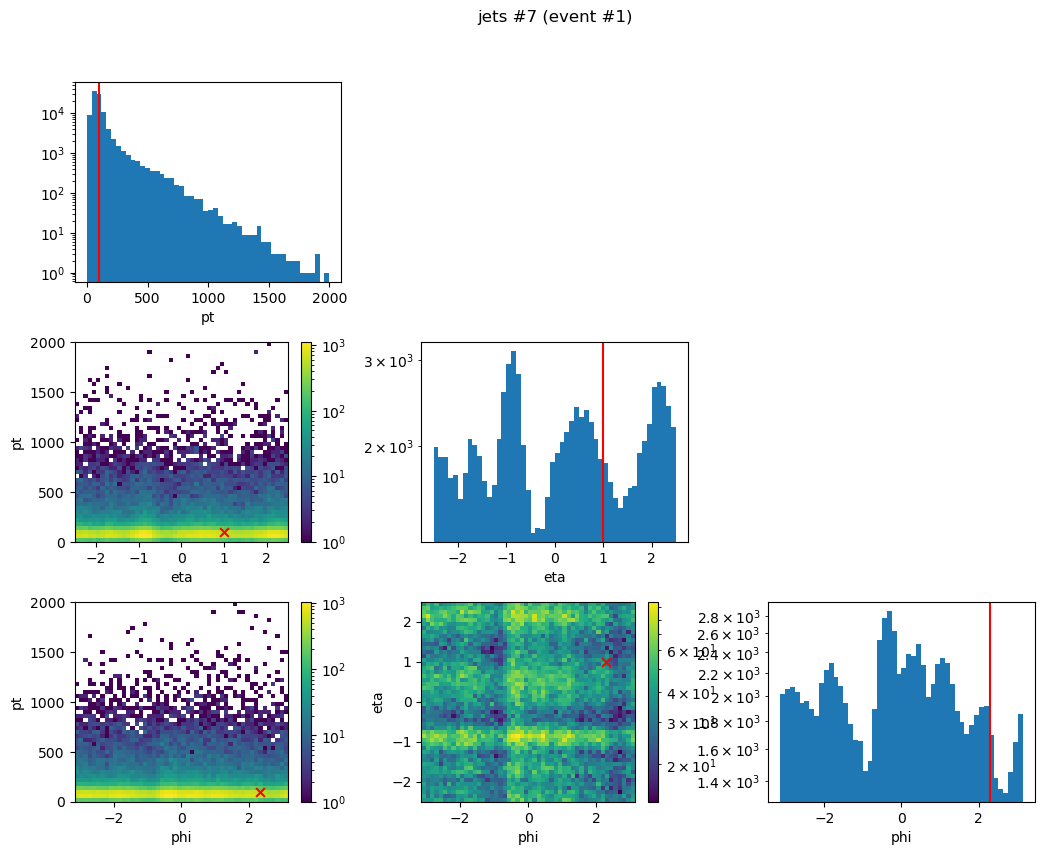

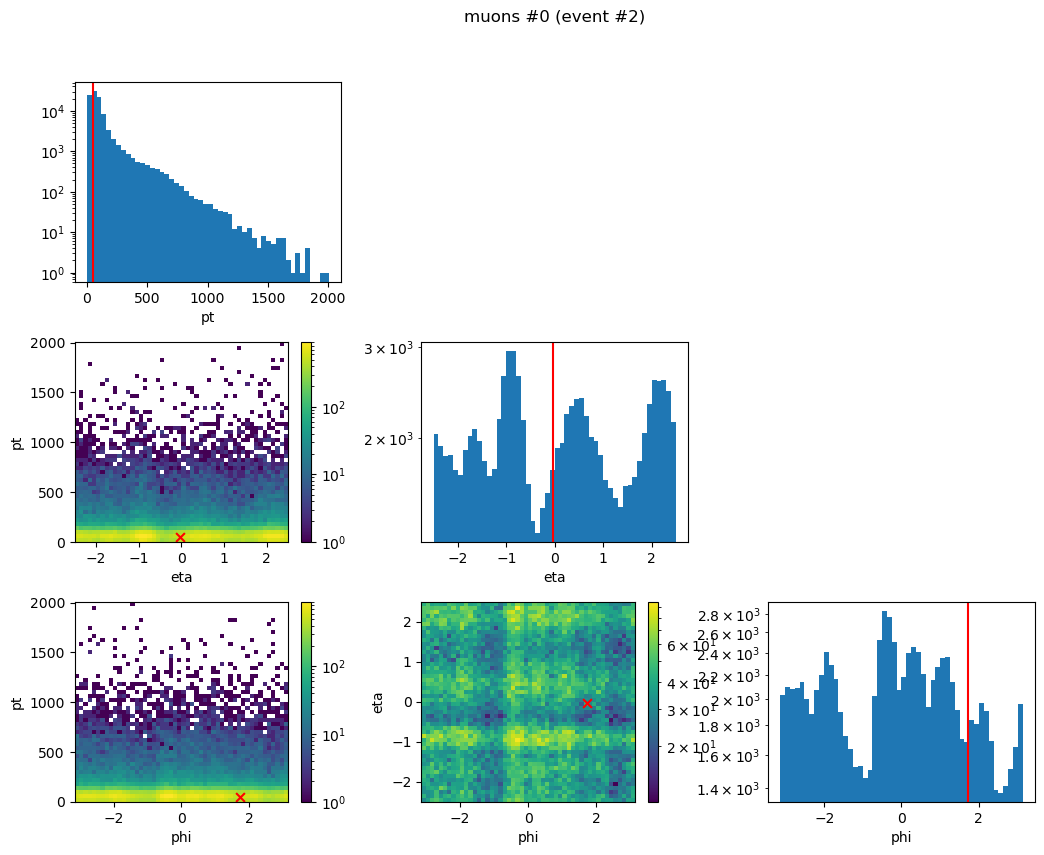

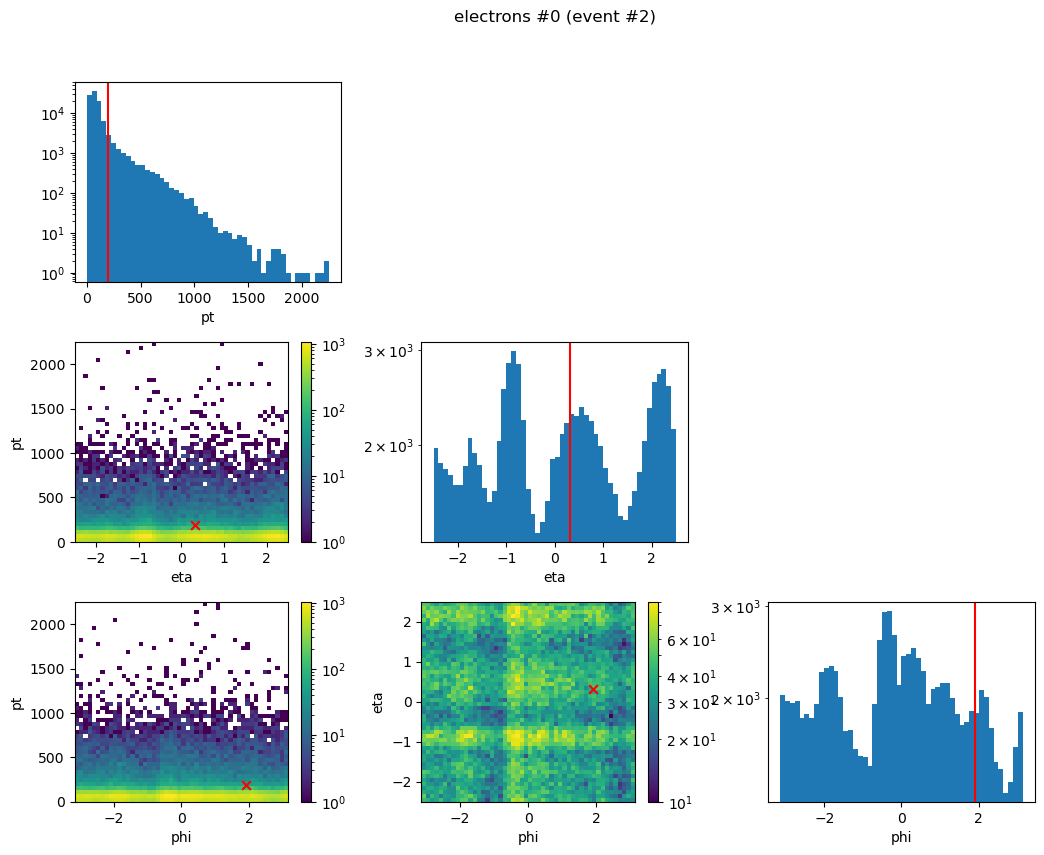

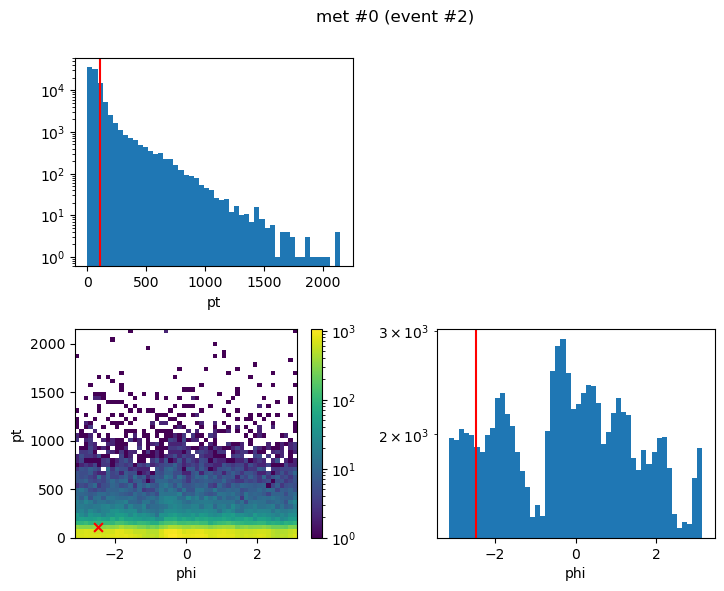

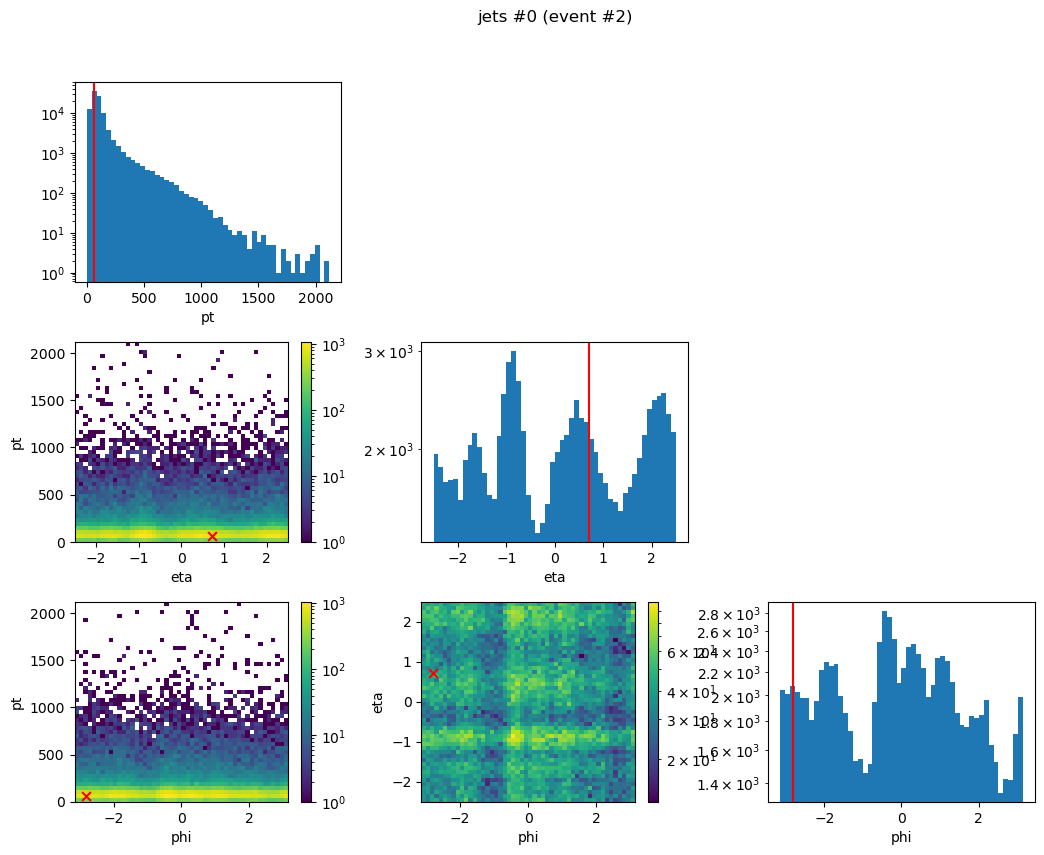

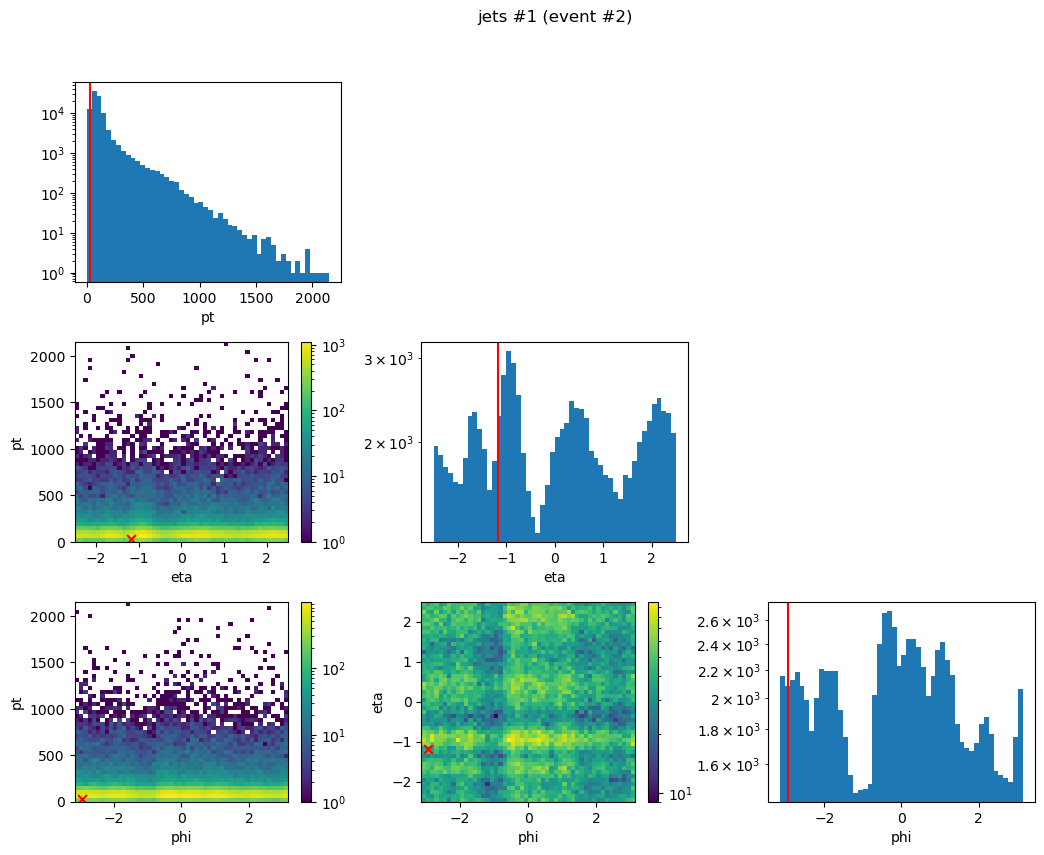

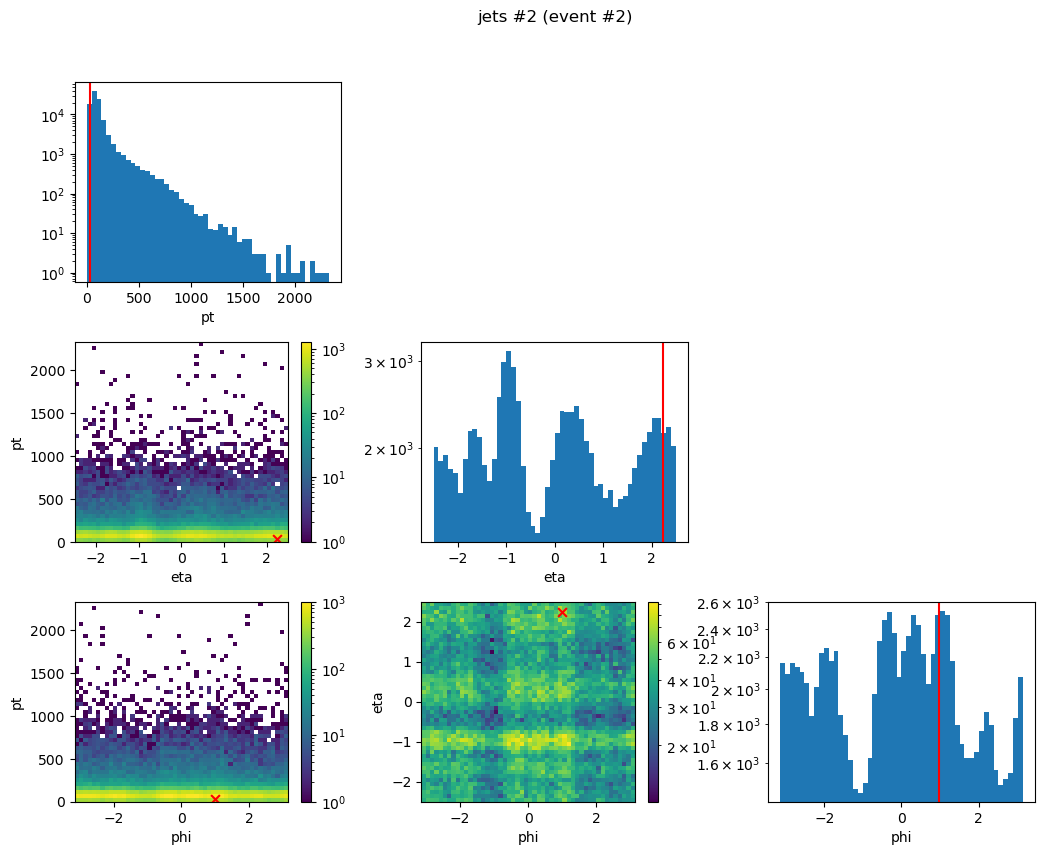

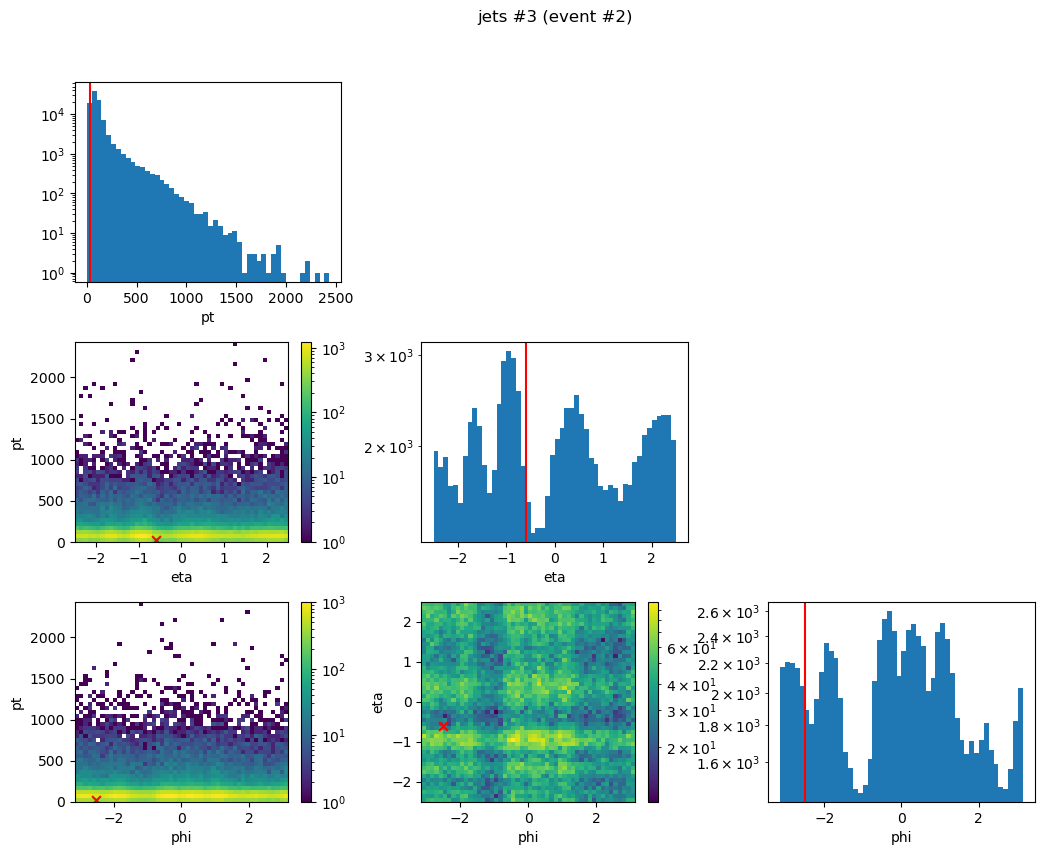

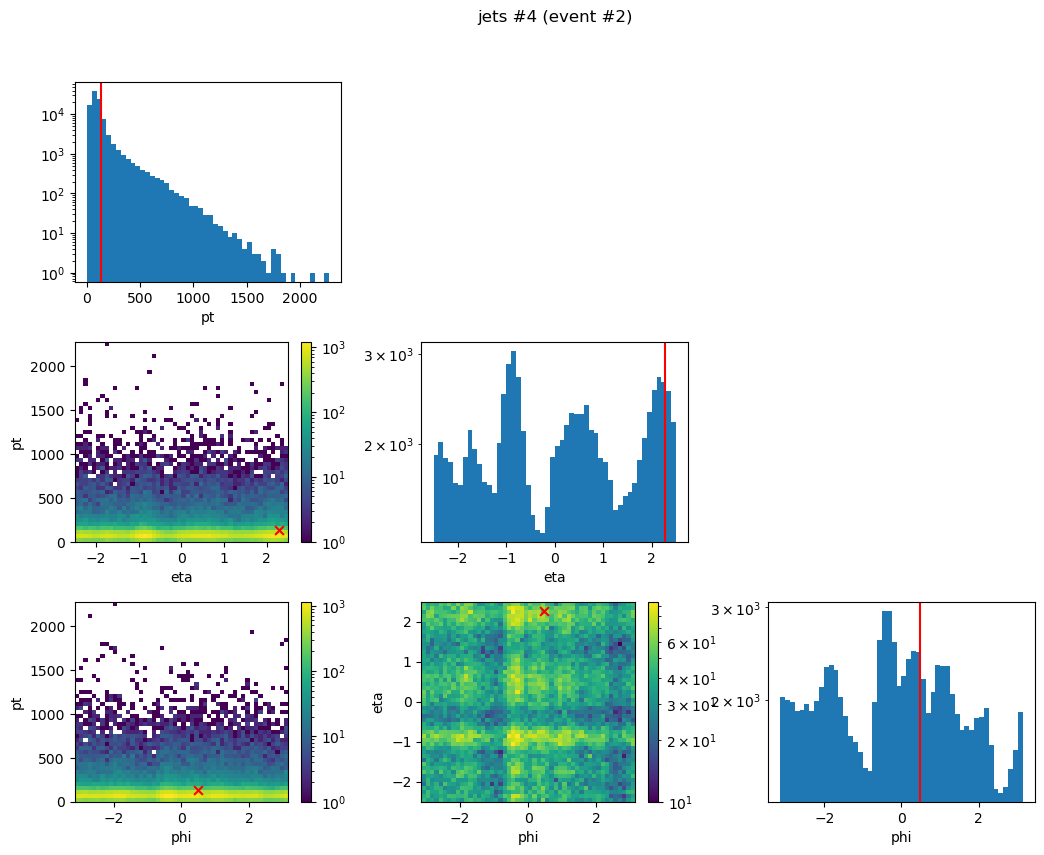

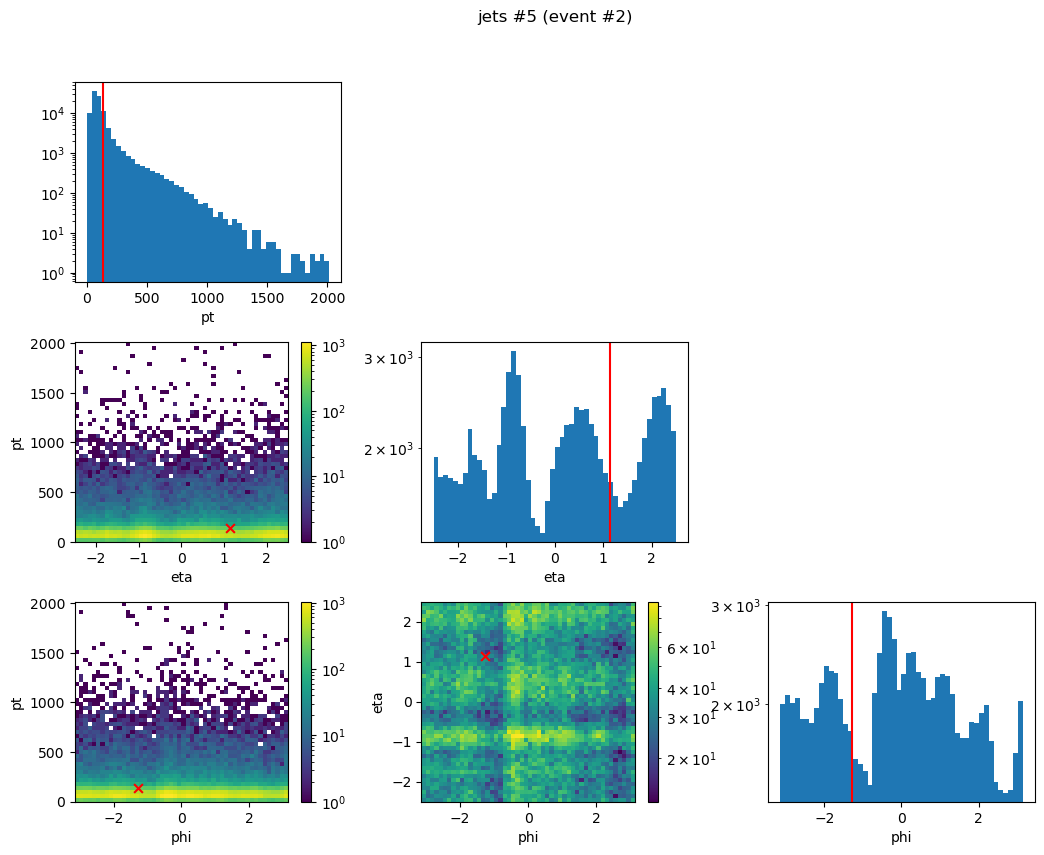

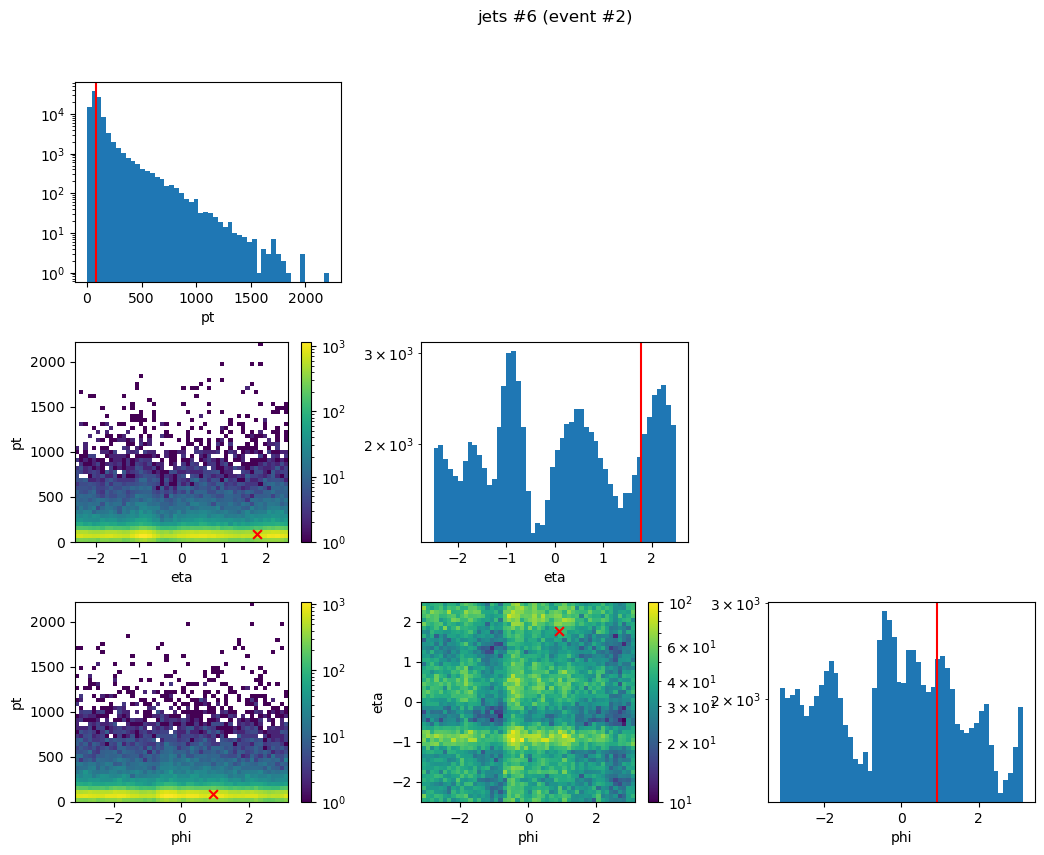

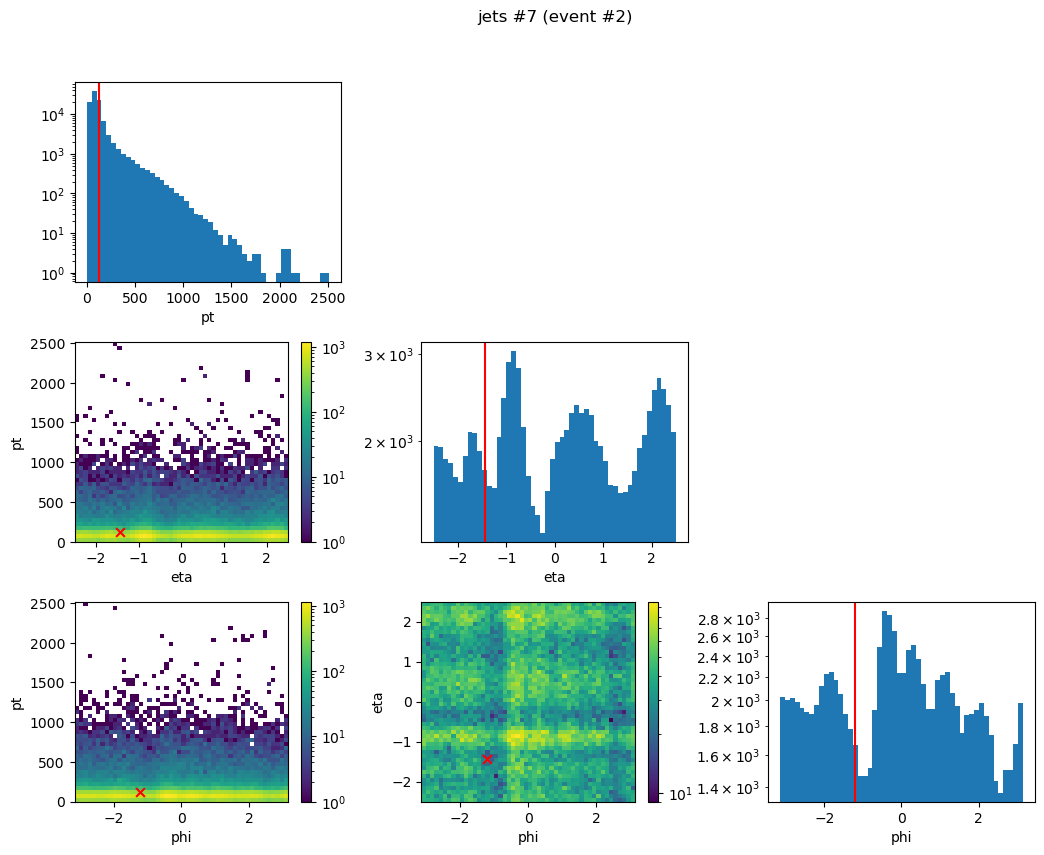

In [13]:
model = model.cuda()
sampling = SamplingCallback(
    dataset = comb_dataset,
    idx_to_monitor = idx_to_monitor,
    N_sample = 100000, 
    frequency = 5,
    raw = True,
    bins = 51,
    log_scale = True,
)
figs = sampling.make_sampling_plots(model,show=True)

Predict:   0%|                                            | 0/1 [00:09<?, ?it/s]


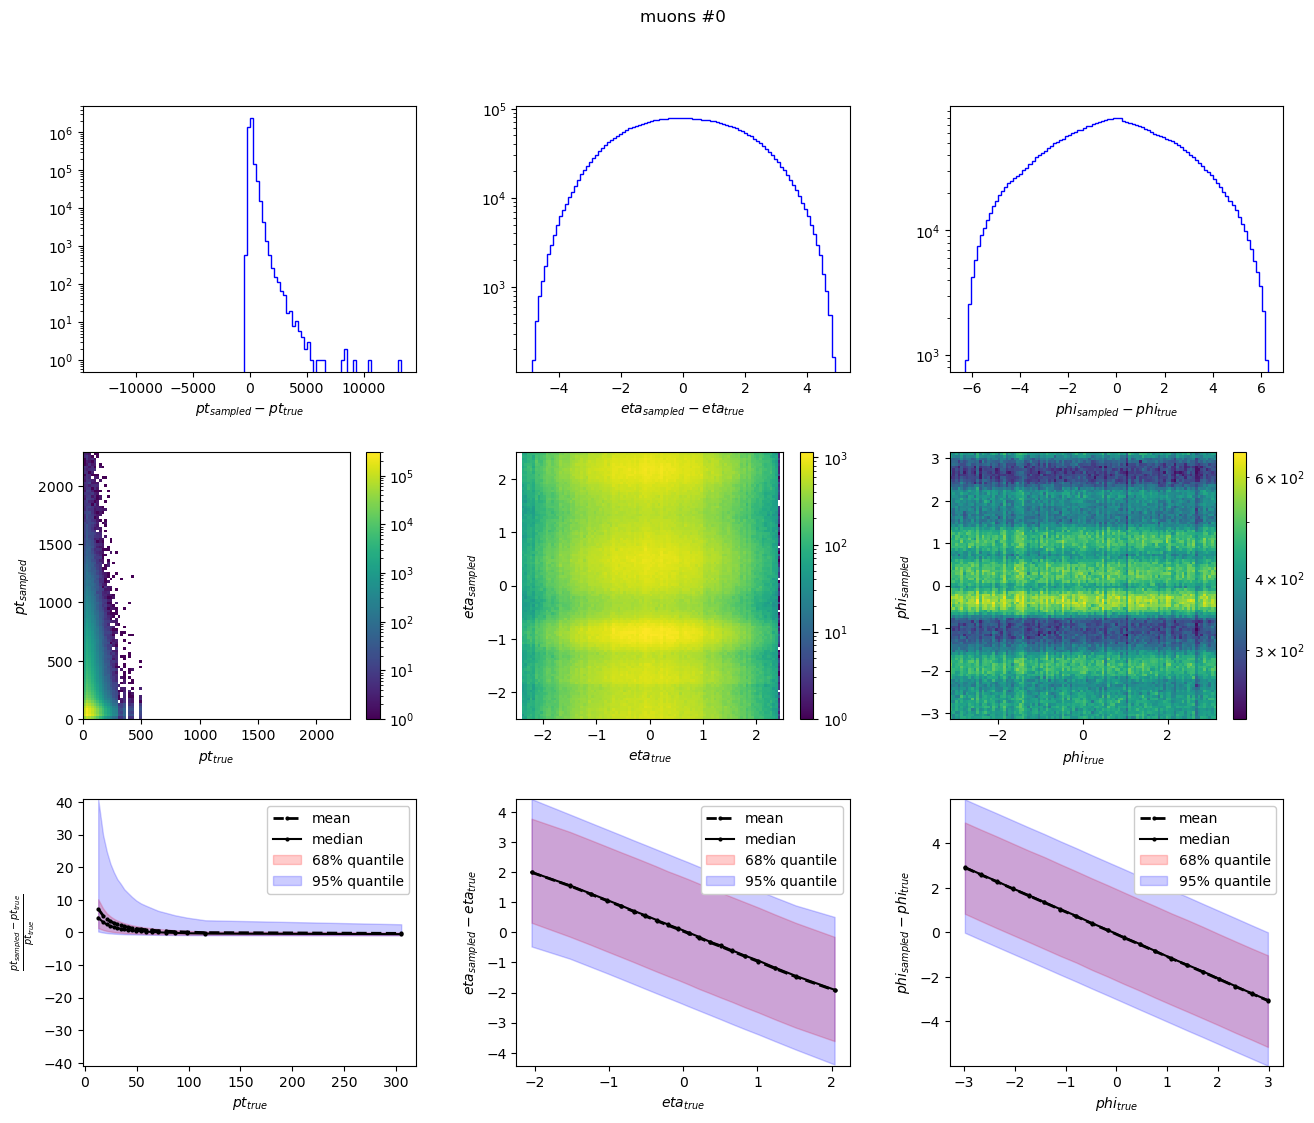

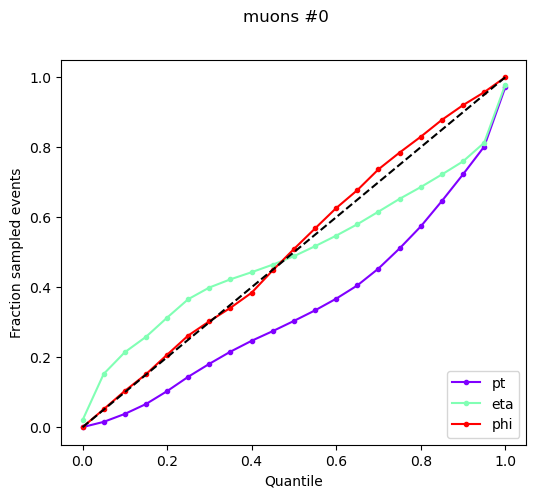

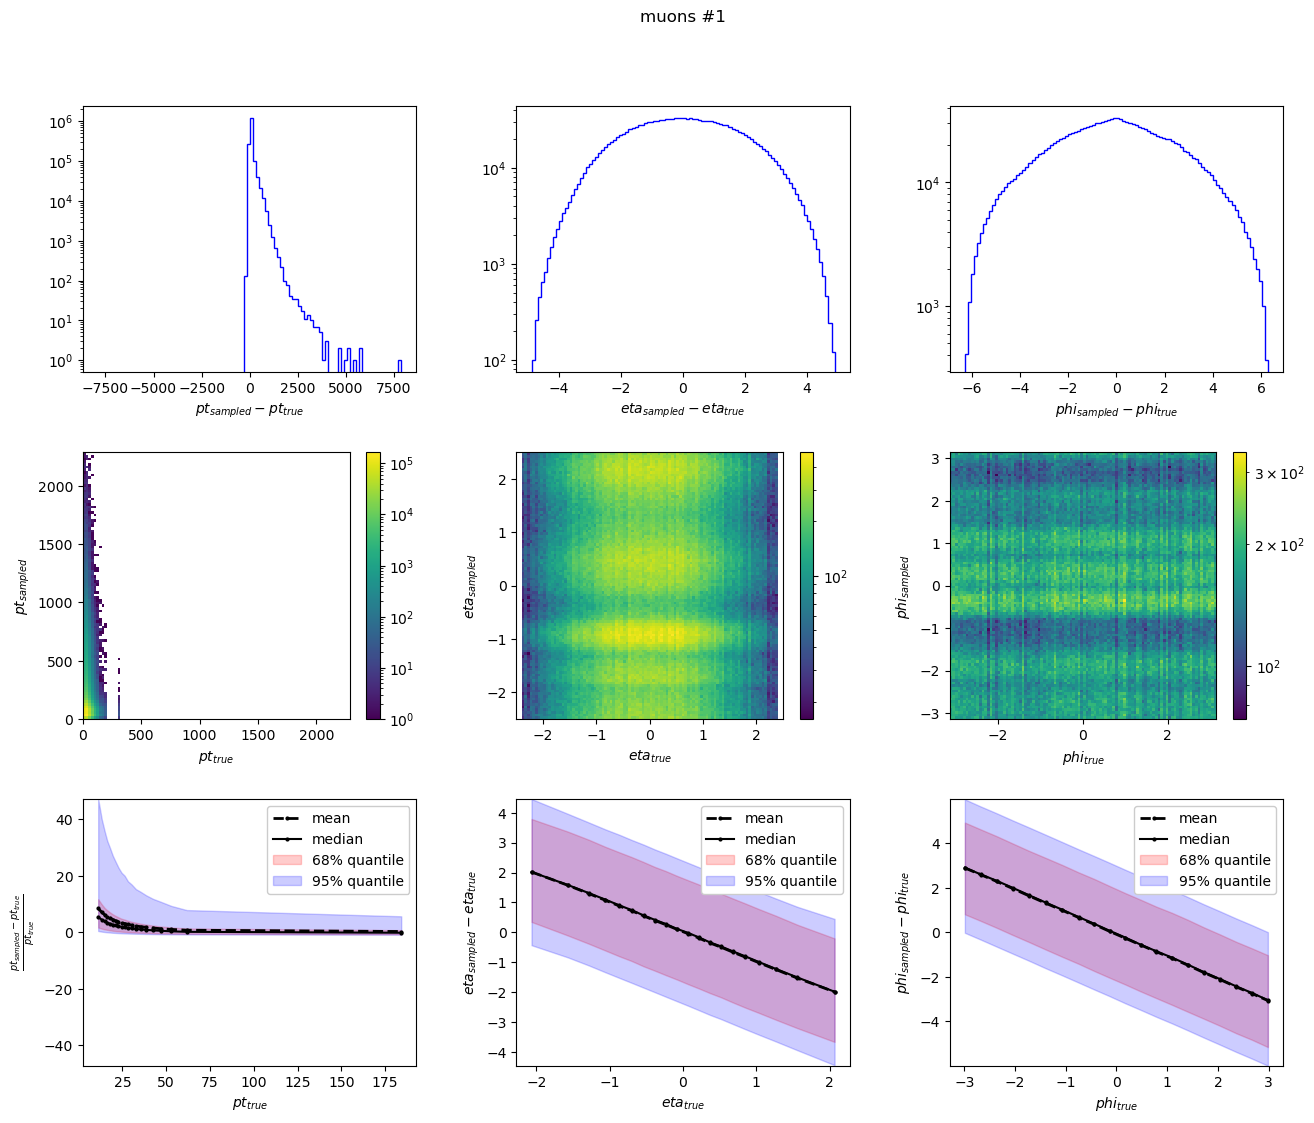

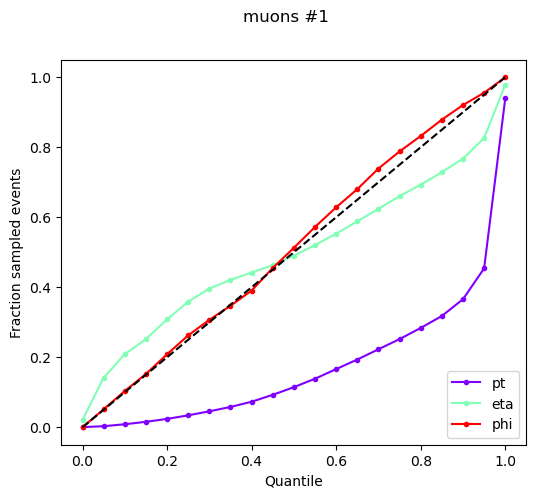

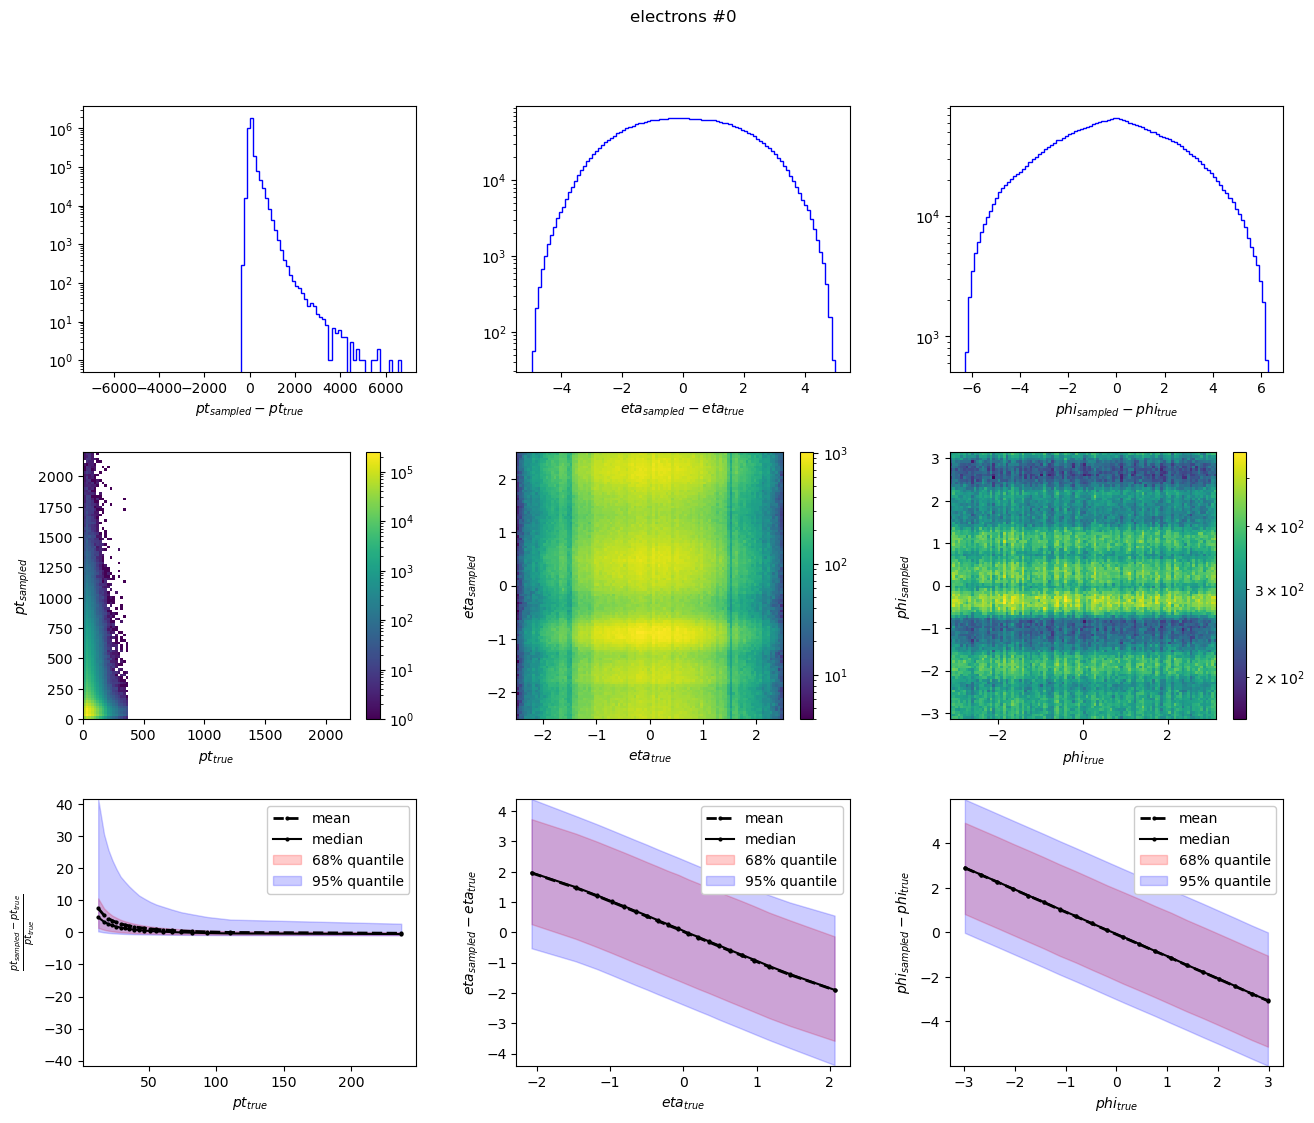

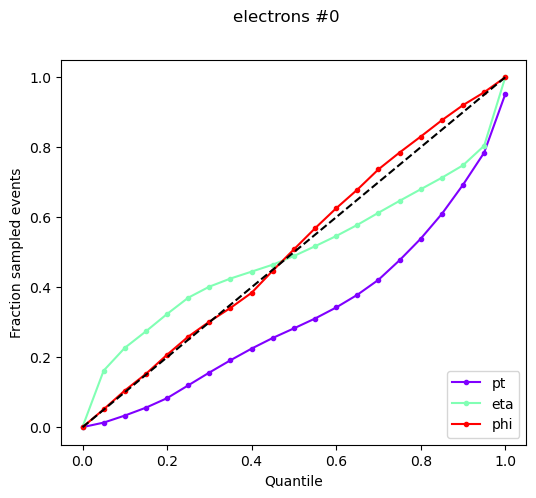

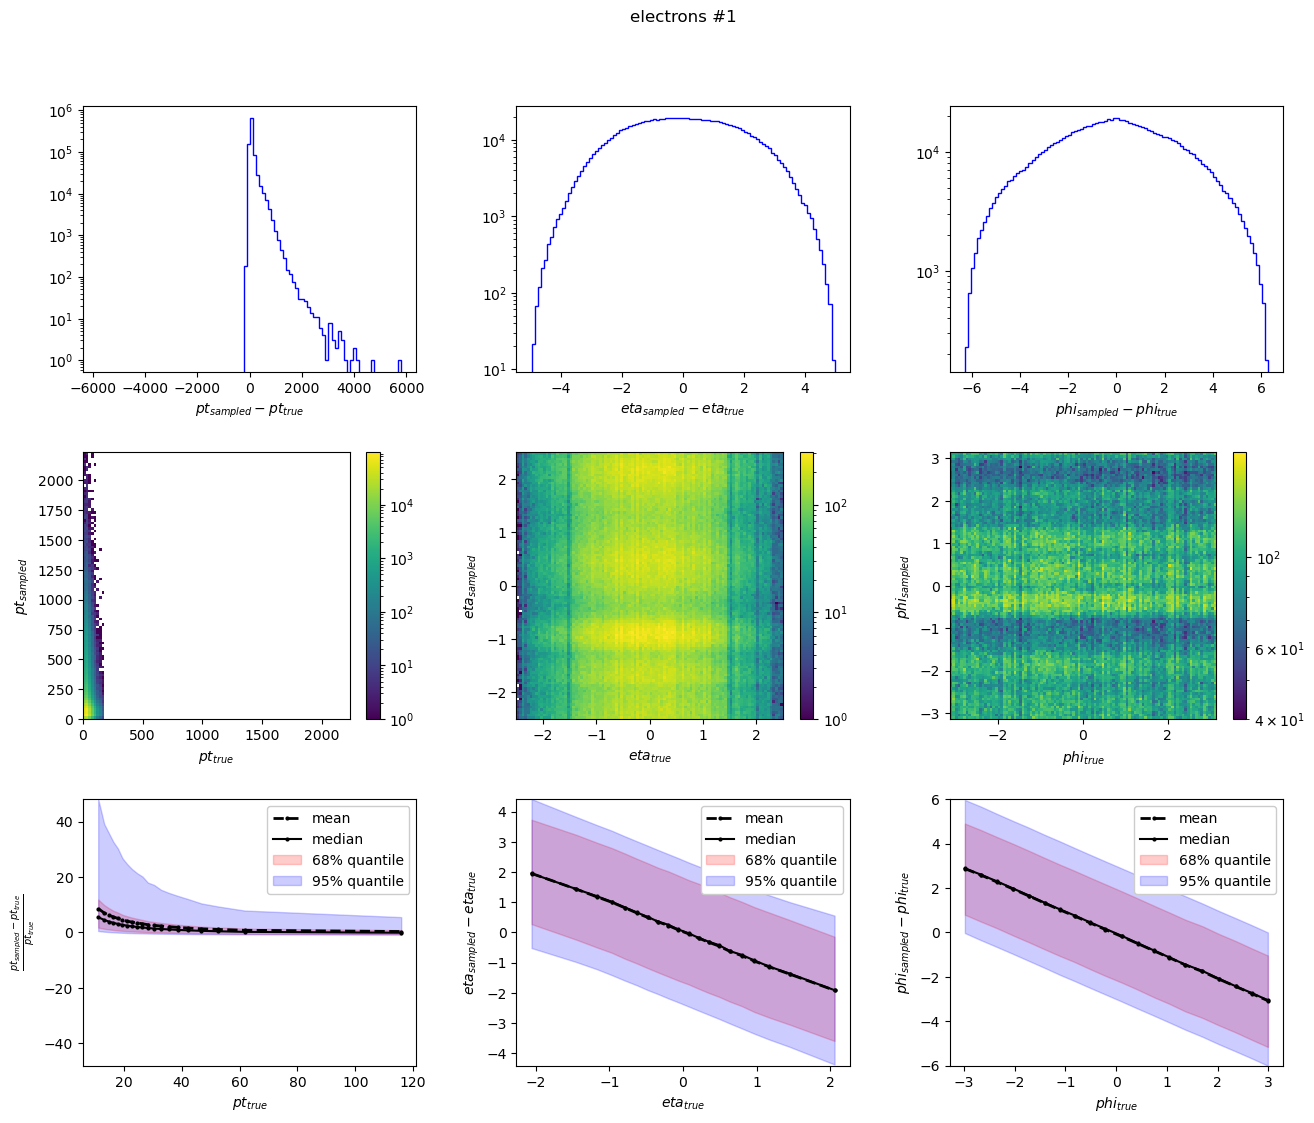

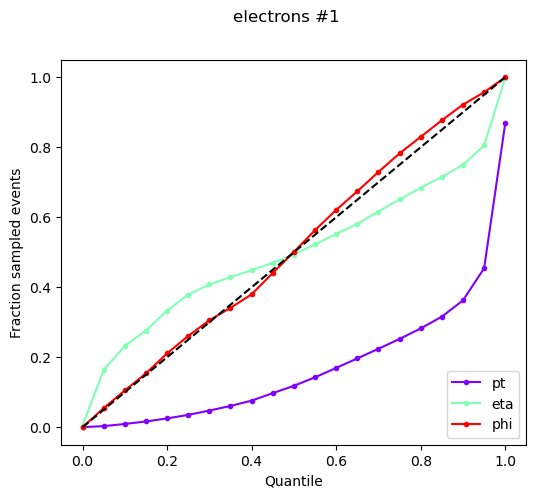

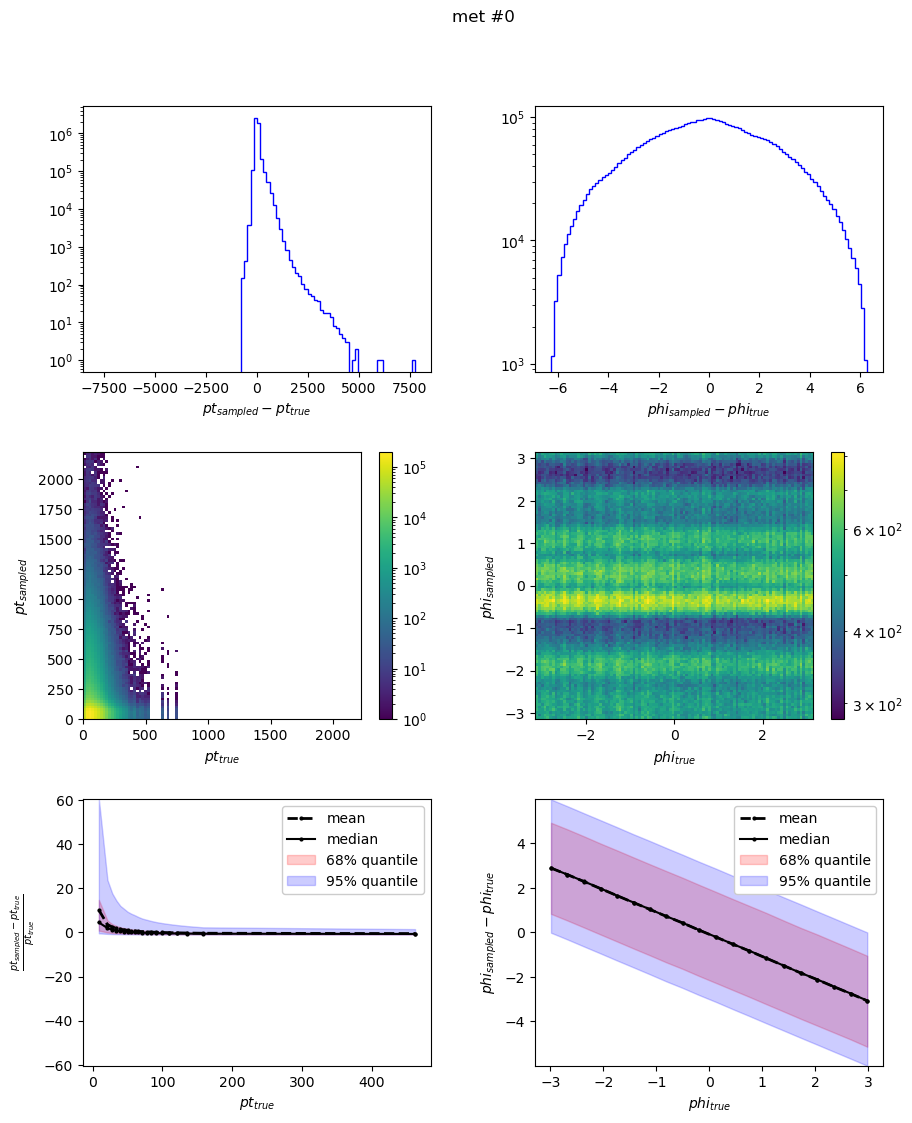

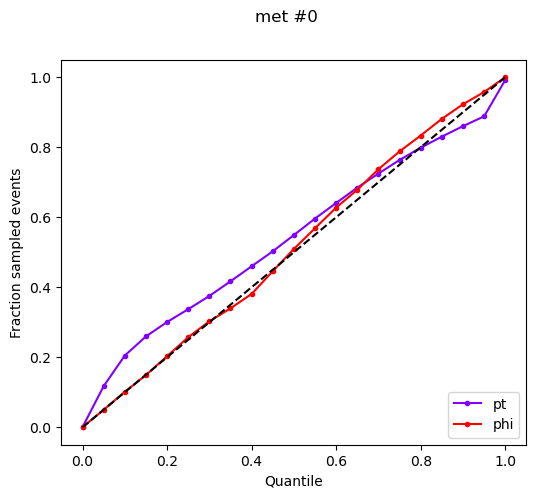

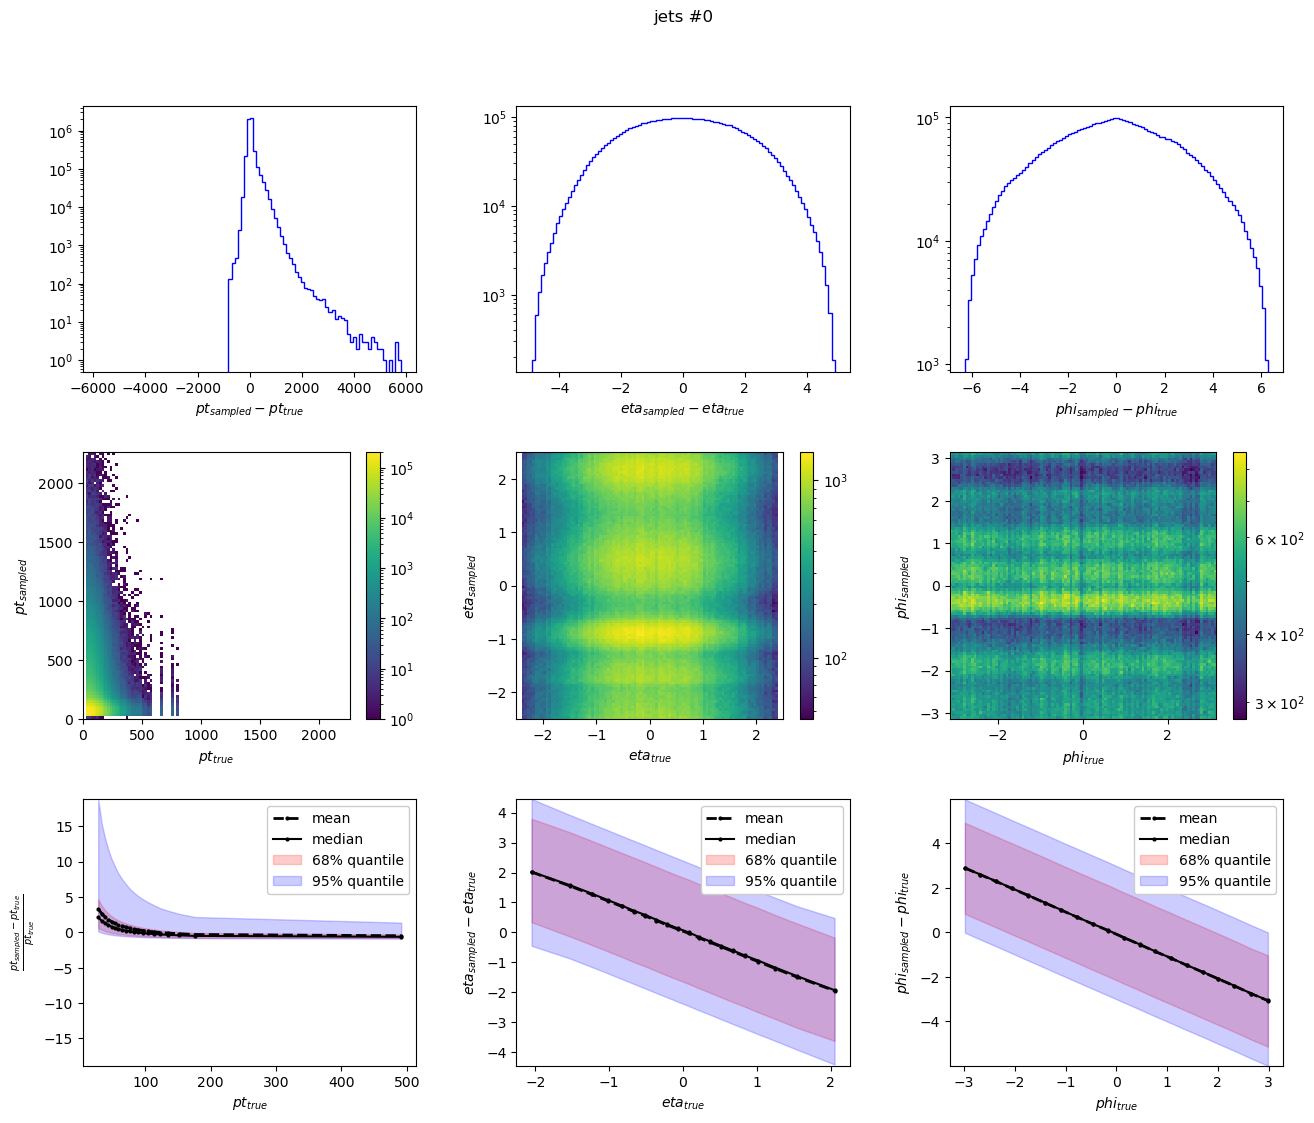

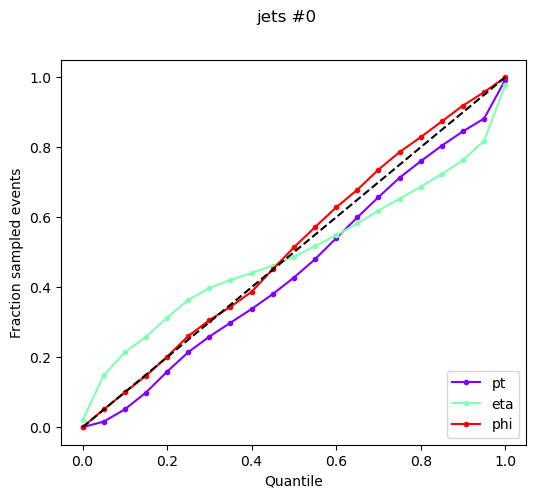

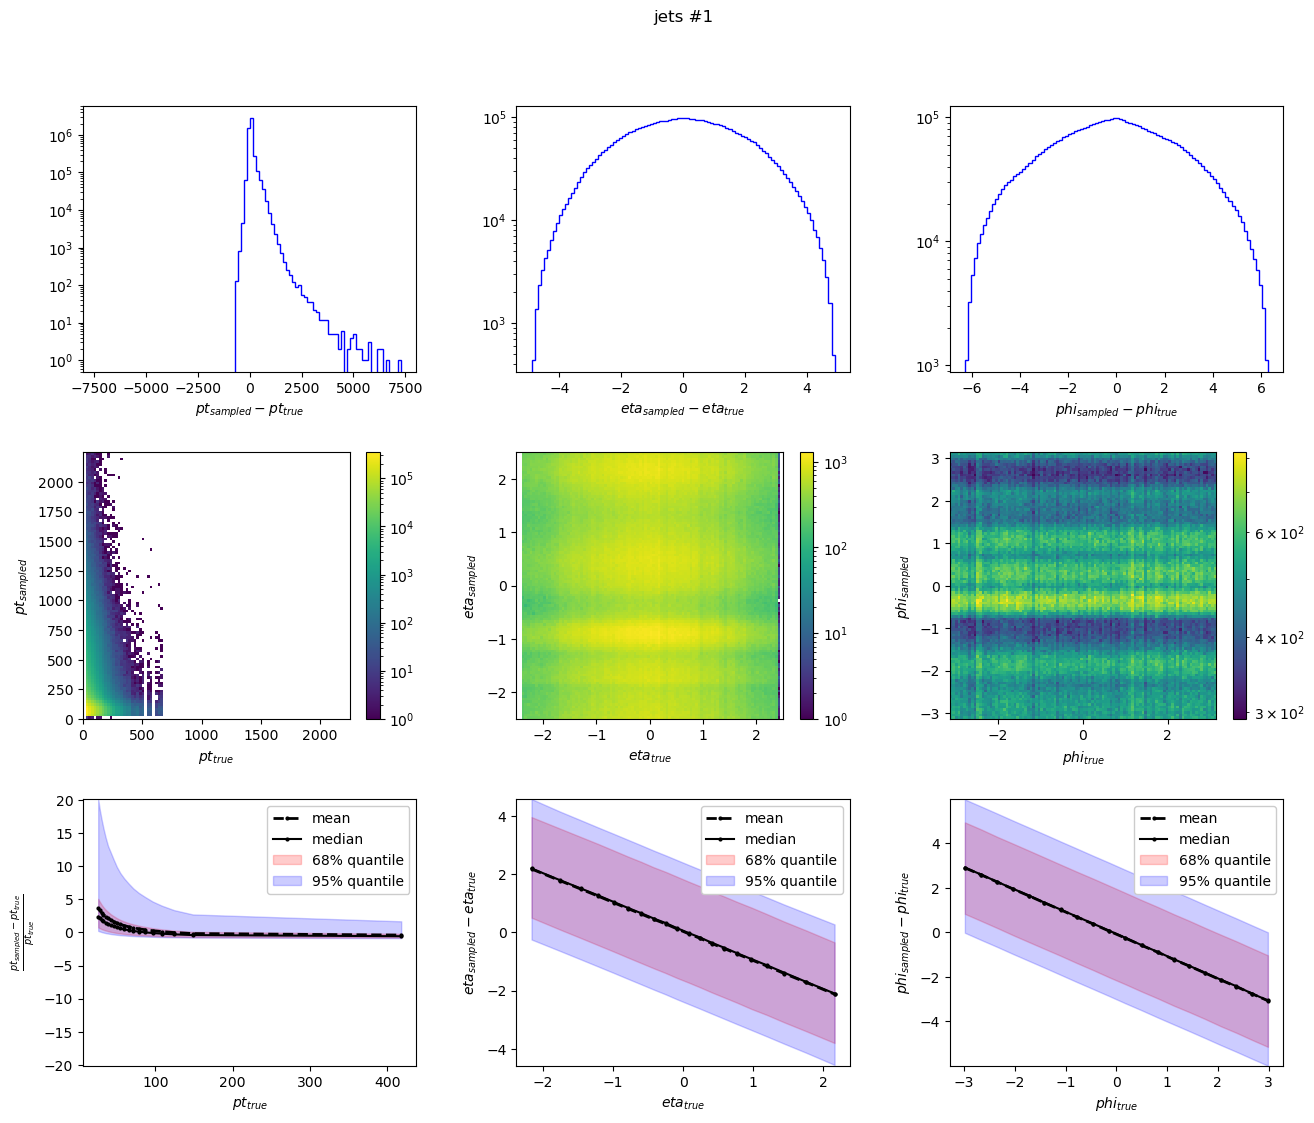

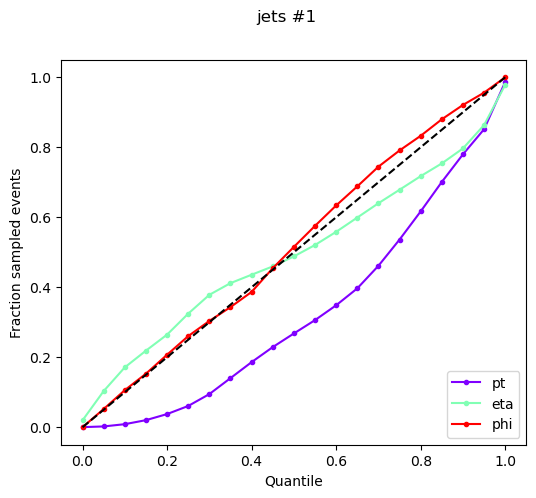

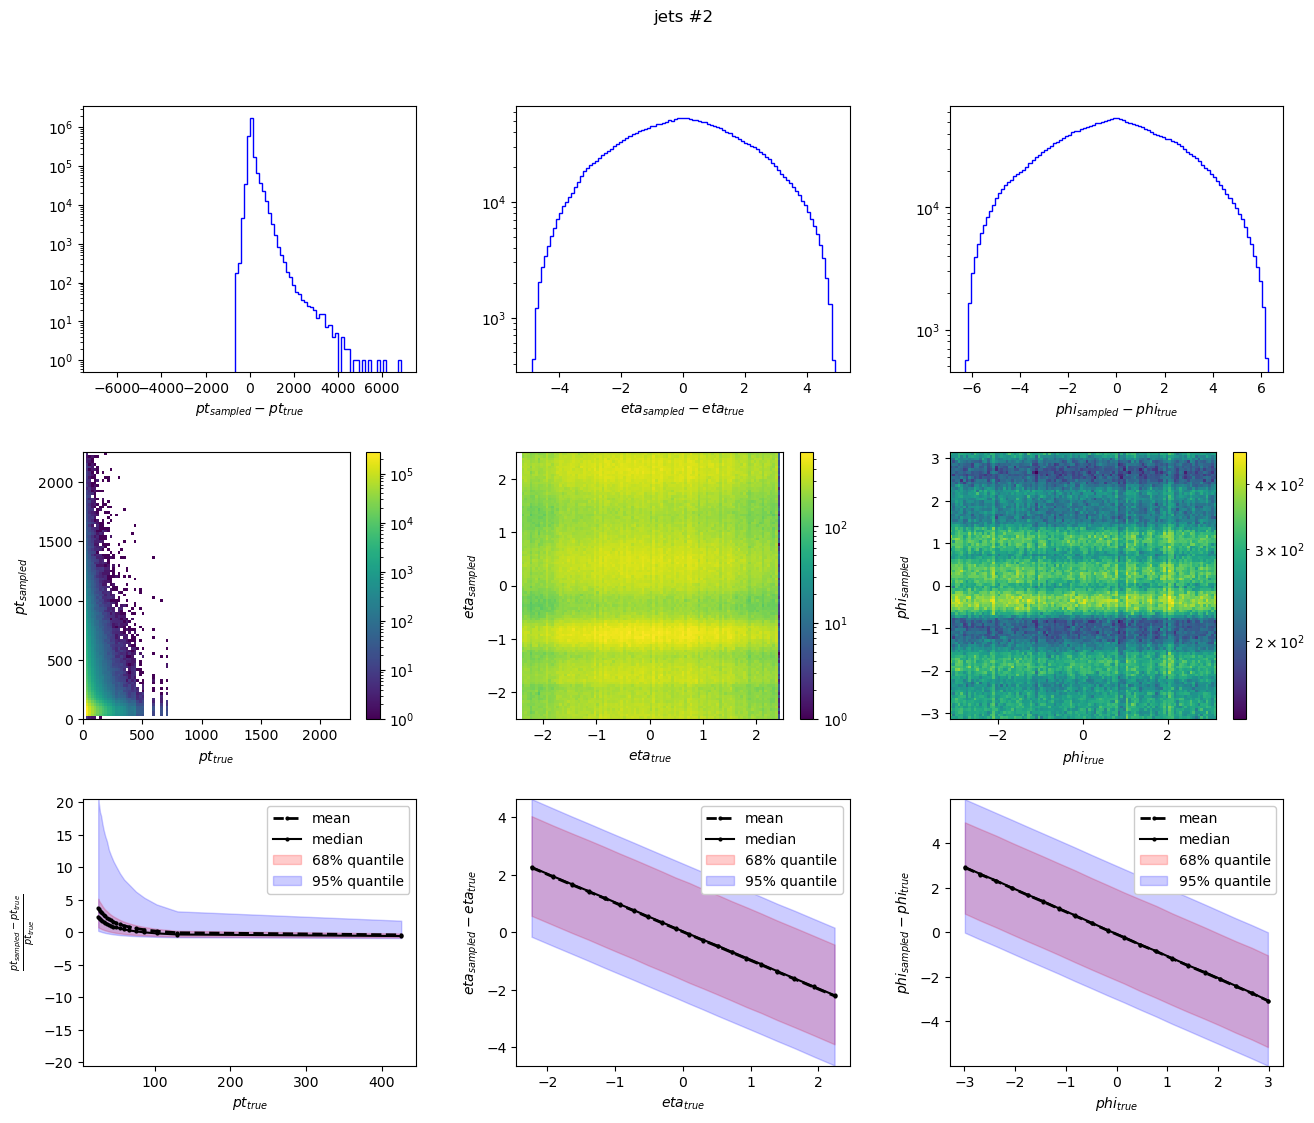

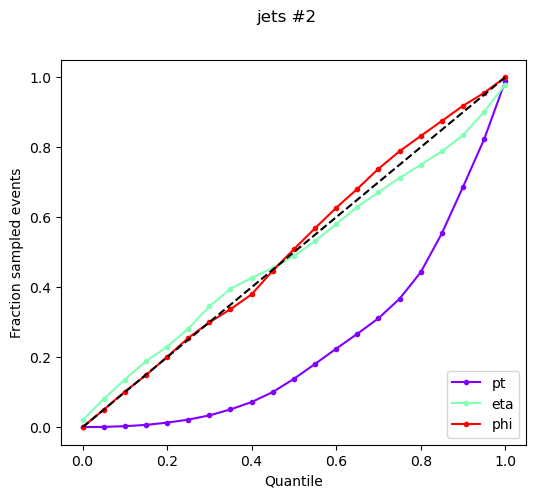

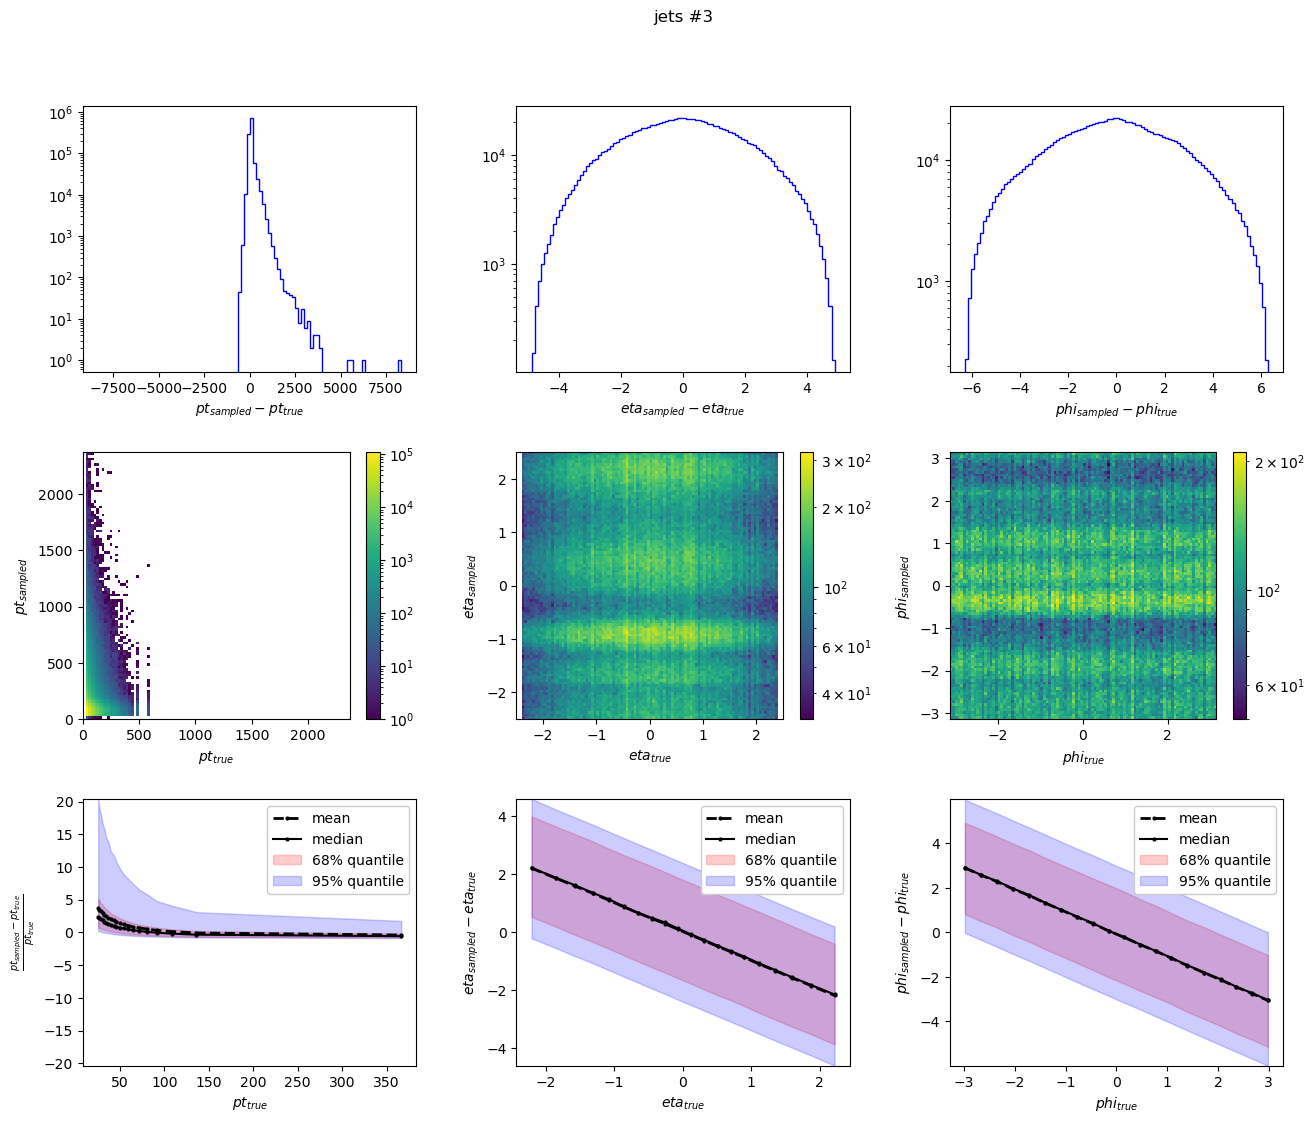

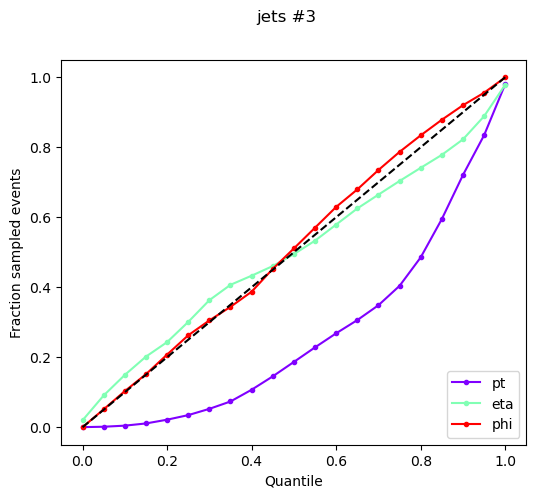

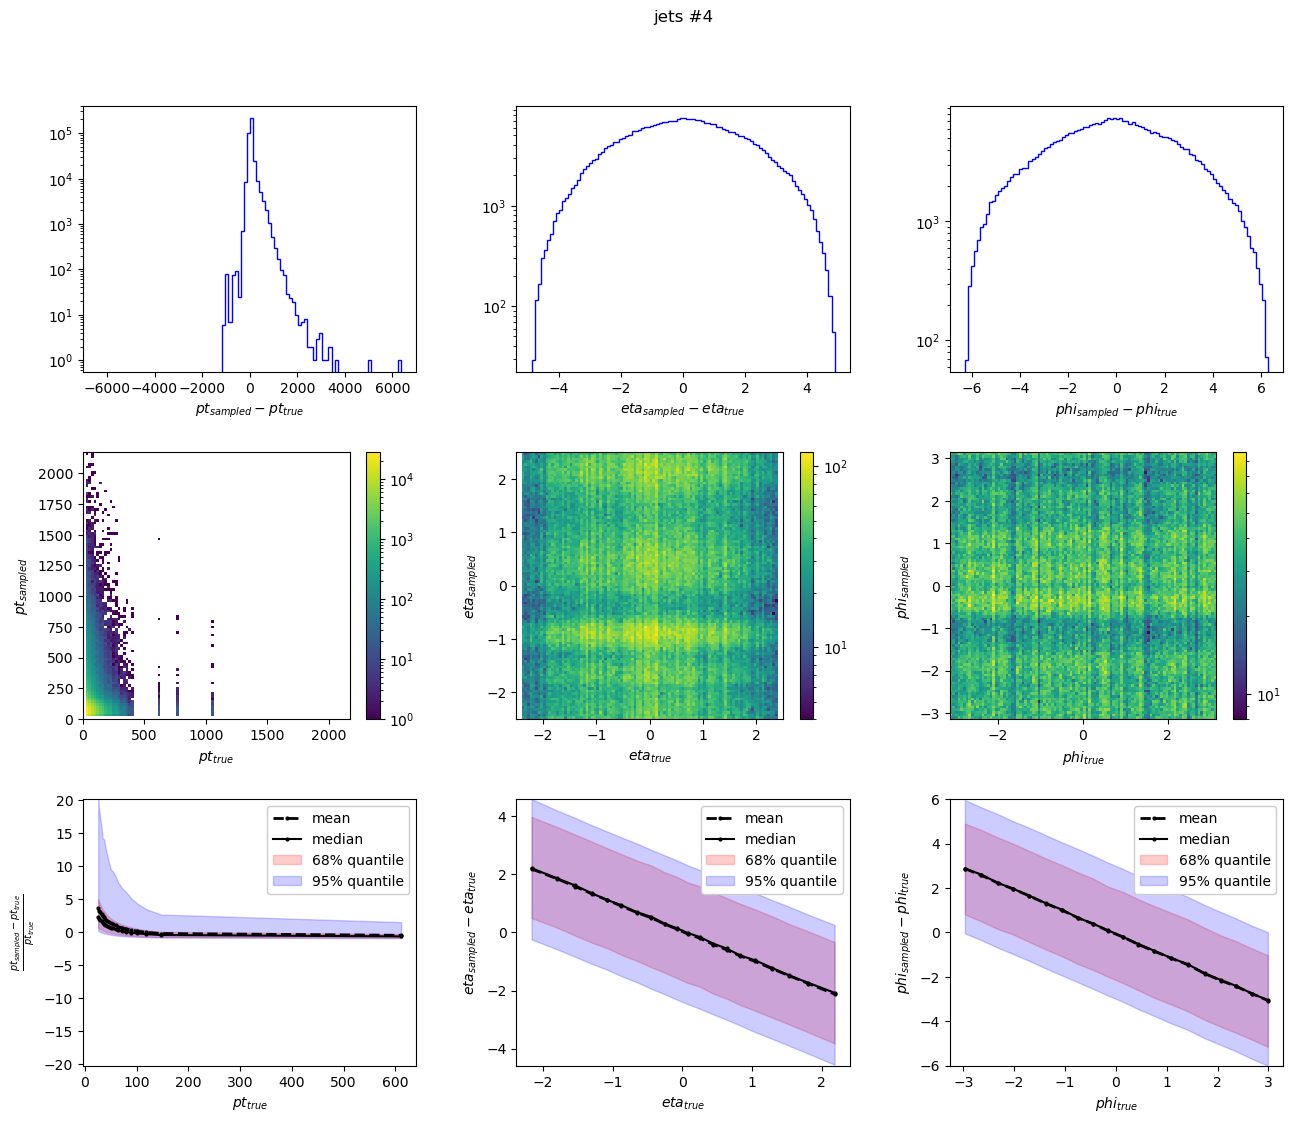

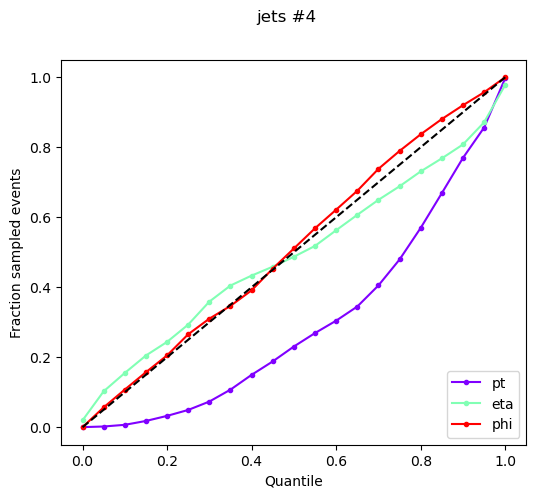

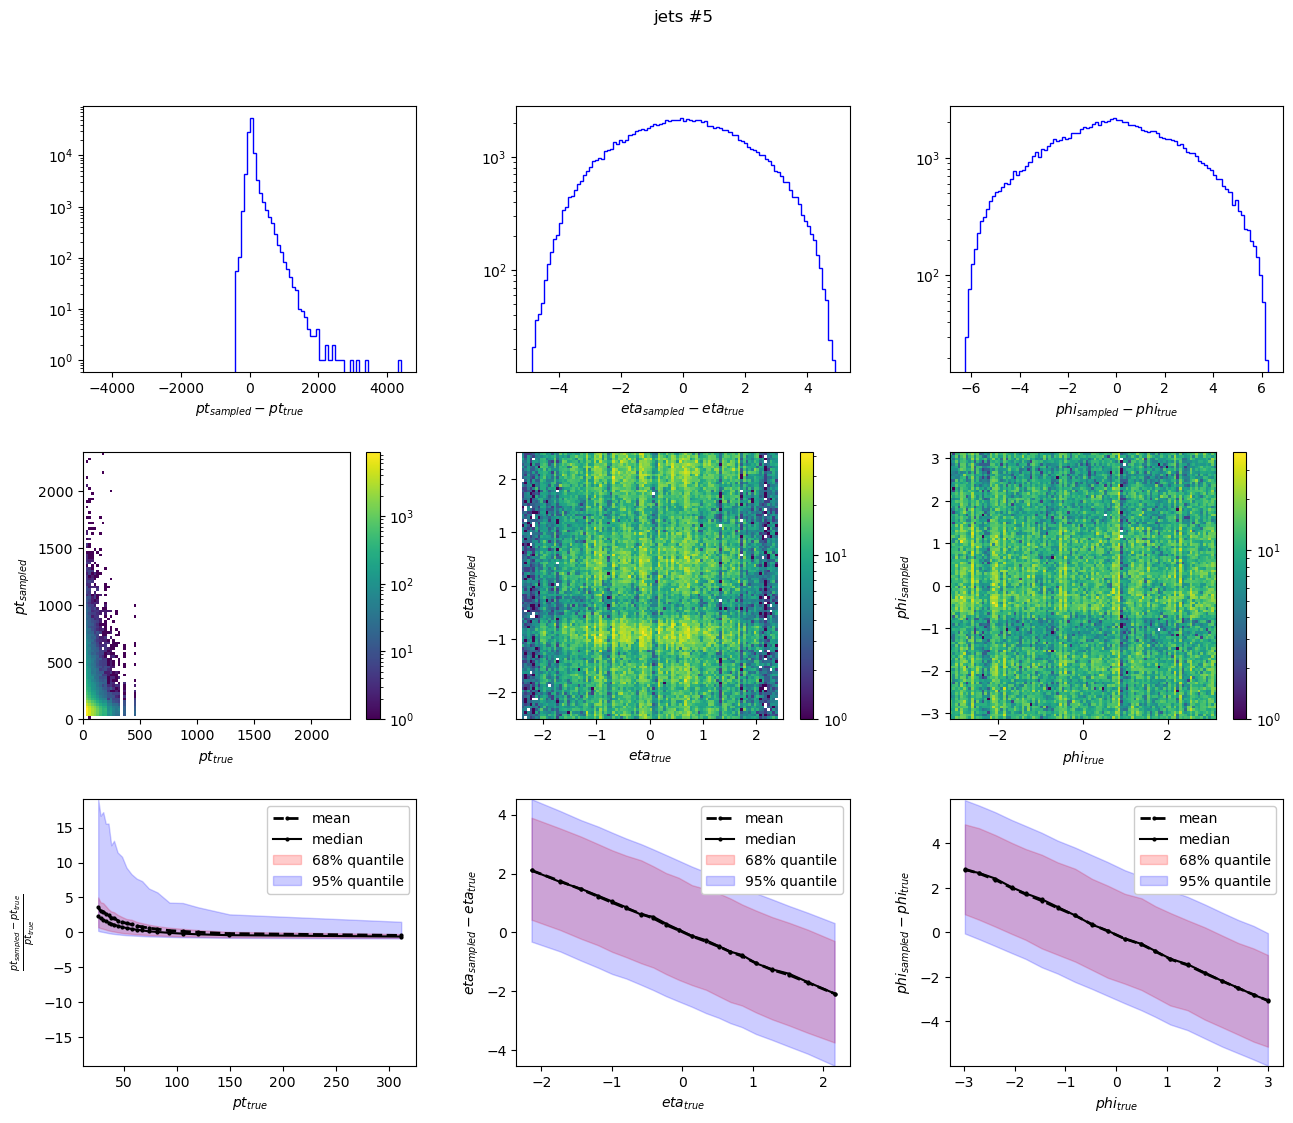

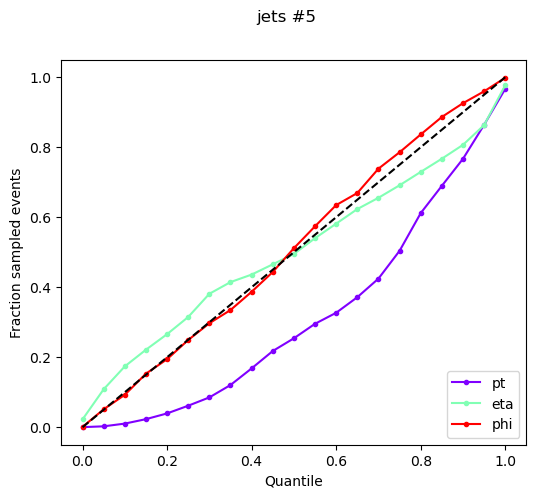

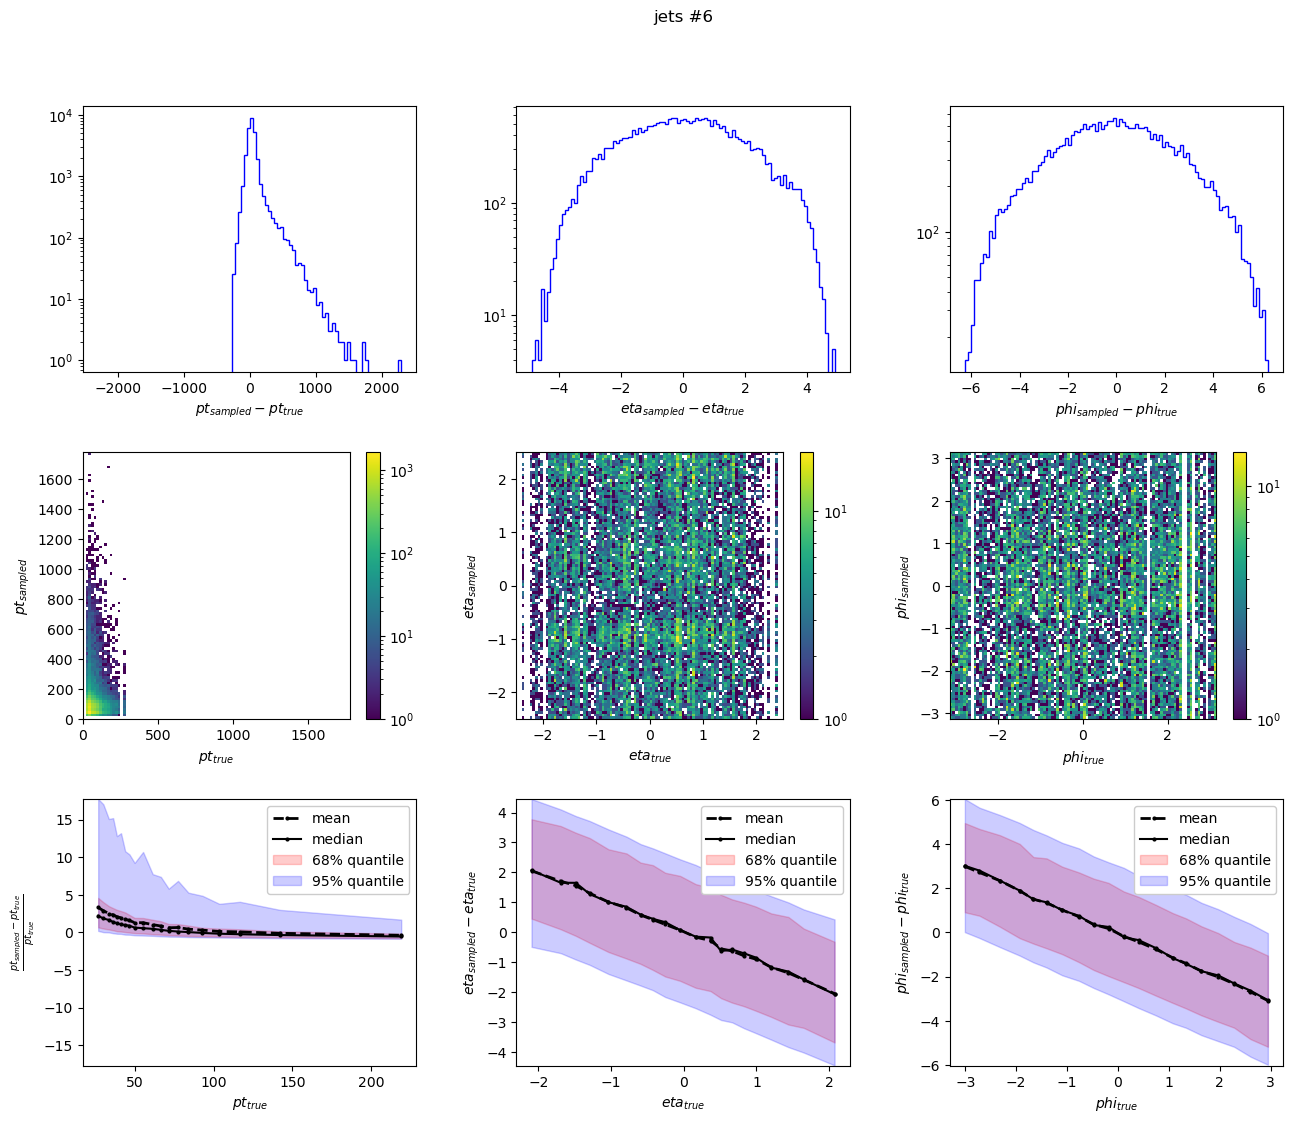

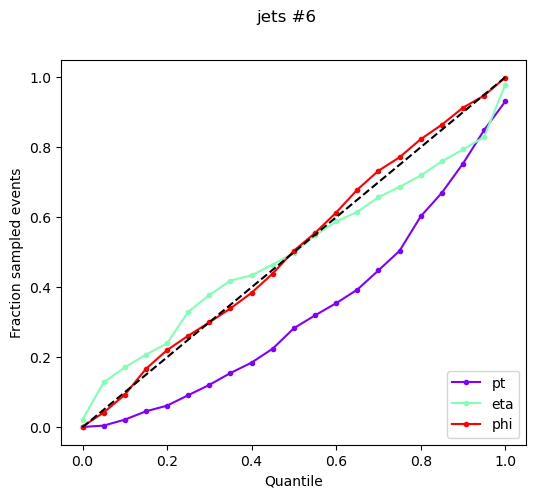

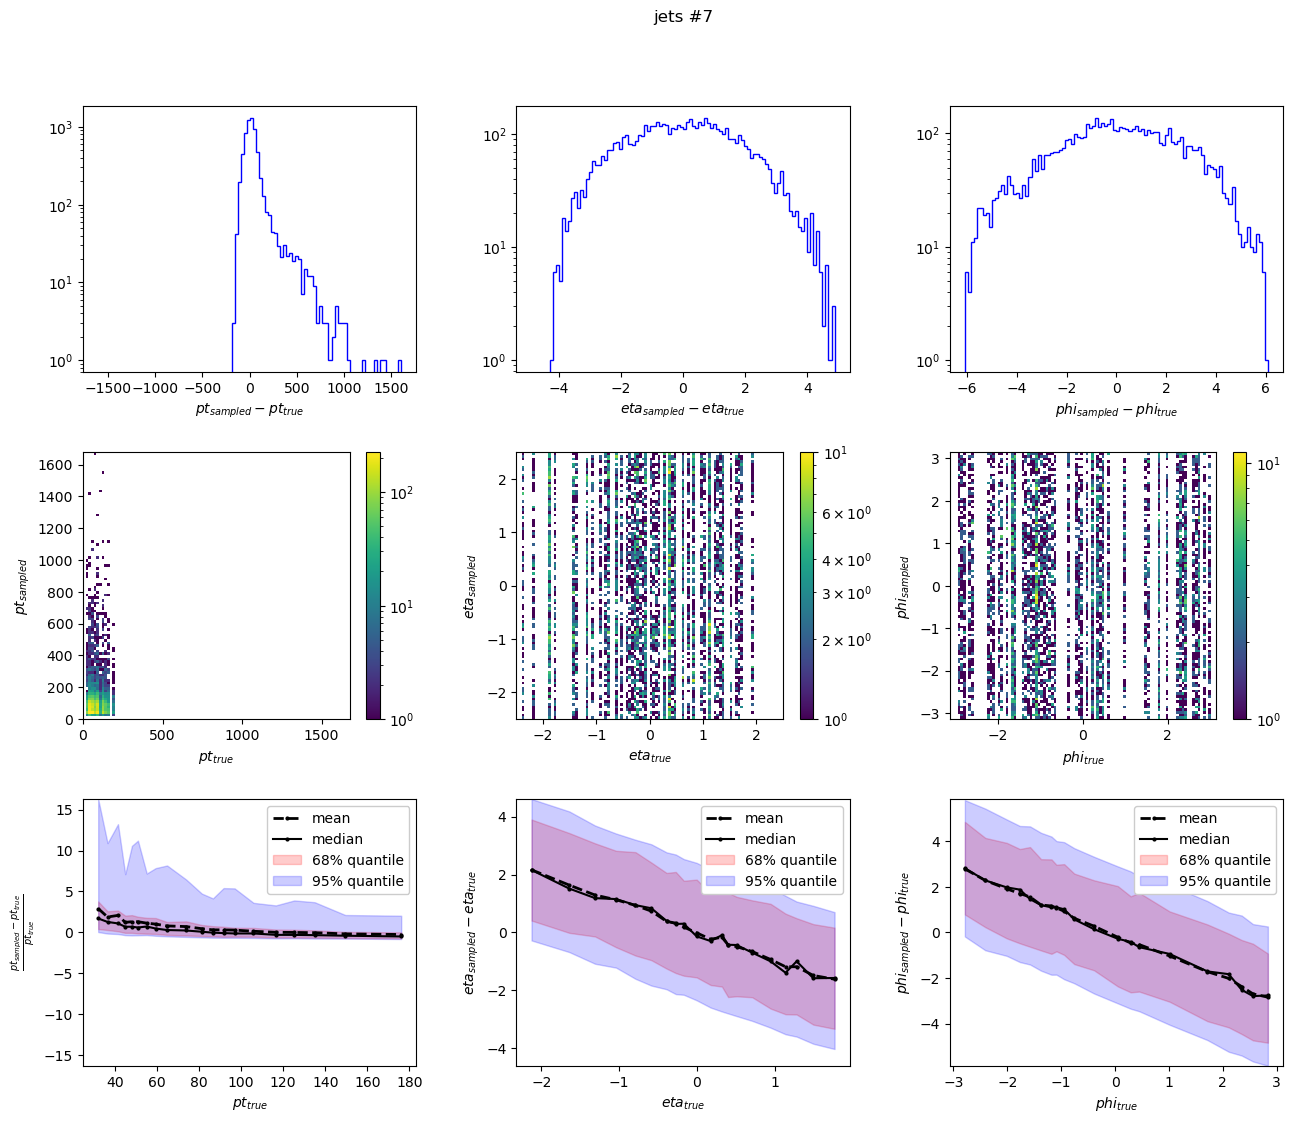

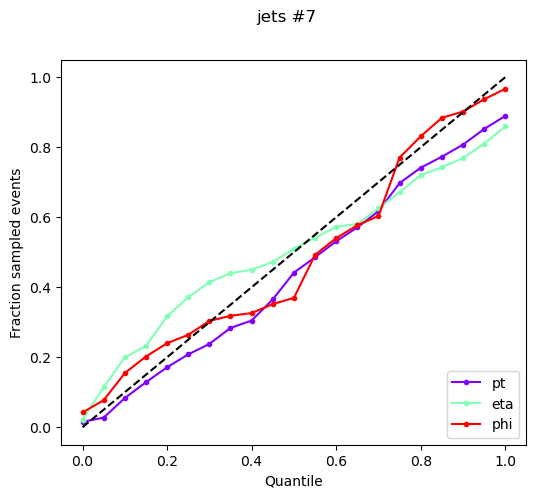

In [14]:
model = model.cuda()
bias = BiasCallback(
    dataset = comb_dataset,
    N_sample = 100,
    frequency = 20,
    raw = True,
    bins = 101,
    points = 20,
    log_scale = True,
    batch_size = 50000,
    N_batch = 1,
)
figs = bias.make_bias_plots(model,show=True)

In [ ]:
##### Parameters #####
epochs = 200
steps_per_epoch_train = math.ceil(len(comb_dataset_train)/loader_comb_train.batch_size)
# steps_per_epoch_valid = math.ceil(len(dataset_valid)/loader_valid.batch_size)

print (f'Training   : Batch size = {loader_comb_train.batch_size} => {steps_per_epoch_train} steps per epoch')
# print (f'Validation : Batch size = {loader_valid.batch_size} => {steps_per_epoch_valid} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-4)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer = optimizer, 
    max_lr = 1e-3, 
    epochs = epochs, 
    steps_per_epoch = steps_per_epoch_train, 
    pct_start = 0.25,
    anneal_strategy='linear', 
    cycle_momentum=True, 
    base_momentum=0.85, 
    max_momentum=0.95, 
    div_factor=1e1, 
    final_div_factor=1e1,
    three_phase = True,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode='min', 
    factor=0.1, 
    patience=10, 
    threshold=0.001, 
    threshold_mode='rel', 
    cooldown=5, 
    min_lr=1e-7
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    sampling,
    bias,
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'HH',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_comb_train,
    val_dataloaders = loader_comb_valid,
)

Training   : Batch size = 1024 => 184 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-hh/677e23e2e8674461b747047b46e82138

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callb

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [ ]:
torch.save(model,'TF_2.pt')

In [ ]:
#model = torch.load('TF.pt')

In [ ]:
figs = sampling.make_sampling_plots(model,show=True)


In [ ]:
model = model.cuda()
bias = BiasCallback(
    dataset = comb_dataset,
    N_sample = 100,
    frequency = 10,
    raw = True,
    bins = 101,
    points = 20,
    log_scale = True,
    batch_size = 10000,
    #N_batch = 1,
)
figs = bias.make_bias_plots(model,show=True)